# Аналитика в Яндекс.Афише

Целью данного проекта является оптимизация маркетинговых затрат Яндекс.Афиши на основании данных за период 12 месяцев: с июня 2017 по конец мая 2018 года. Используя 1) логи сервера с данными о посещениях сайта Яндекс.Афиши, 2) выгрузку всех заказов за этот период и 3) статистику рекламных расходов, мы изучим:  
* как люди пользуются продуктом,  
* когда они начинают покупать,  
* сколько денег приносит каждый клиент,
* когда клиент окупается.

# Оглавление

1. [Загружаем библиотеки, изучаем данные](#1step)
2. [Подготовка данных](#2step)   
   2.1. [Изменение типа данных](#2.1step) 
3. [Анализ данных](#3step)   
   3.1. [Анализ продукта](#3.1step)  
   3.2. [Анализ продаж](#3.2step)  
   3.3. [Анализ маркетинговых затрат](#3.3step) 
4. [Общий вывод](#4step)   

# Шаг 1. Загружаем библиотеки, изучаем данные. <a name="1step"></a>

In [1]:
# отключим предупреждения Anaconda
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np

#библиотеки для визулизации
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates
import seaborn as sns
%matplotlib inline

Прочитаем файлы и сохраним их в переменных visits, orders и costs:

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

Просмотрим содержание файла, для этого будет достаточно 5 первых строк:

In [3]:
for data in [visits,orders,costs]:
    display(data.head())

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [4]:
for data in [visits,orders,costs]:
    display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


None

В нашем распоряжении имеется 3 датасета, которые содержат следующую информацию:  

1. **Visits**  
Содержит информацию о посещениях сайта за период с июня 2017 по конец мая 2018 года. Всего за этот период было зафиксировано 359 400 посещений. Информация в датасете собрана по 5 столбцам:  
    - Uid — уникальный идентификатор пользователя
    - Device — категория устройства пользователя
    - Start Ts — дата и время начала сессии
    - End Ts — дата и время окончания сессии
    - Source Id — идентификатор рекламного источника, из которого пришел пользователь


2. **Orders**  
Содержит информацию о заказах, размещенных за исследуемый период. Всего за период было сделано 50 415 заказов. Информация в датасете представлена в 3 столбцах:  
    - Uid — уникальный id пользователя, который сделал заказ
    - Buy Ts — дата и время заказа
    - Revenue — выручка Яндекс.Афиши с этого заказа


3. **Costs**  
Содержит информацию о затратах на маркетинг. Датасет включает 2 542 строки и 3 столбца:  
    - source_id — идентификатор рекламного источника
    - dt — дата
    - costs — затраты на этот рекламный источник в этот день
    
Во всех датасетах отсутствуют пропуски, однако тип данных некоторых столбцов необходимо заменить на более корректные и более удобные для дальнейшего анализа. 

Кроме того названия столбцов датасетов Visits и Orders начинаются с большой буквы, что неудобно для работы, поэтому переименуем столбцы, а именно приведем названия к нижнему регистру, также заменим пробелы на нижнее подчеркивание в тех столбцах, где это актуально:

In [5]:
def change_col_names(data):
    data.columns = data.columns.str.lower()
    data.columns = data.columns.str.replace(' ','_')

In [6]:
change_col_names(visits)
change_col_names(orders)

## Вывод

Имеющиеся файлы с данными содержат всю необходимую информацию, позволяющую провести анализ бизнес-показателей по Яндекс.Афише. Прежде чем приступить к анализу, проведем предобработку данных, а именно изменим типы данных в следующих столбцах:

* **Visits**: Start Ts и End Ts - изменим тип object на тип данных datetime
* **Visits**: Uid - изменим тип uint64 (целочисленный тип) на тип данных object, поскольку это идентификатор пользователя

* **Orders**: Buy Ts - изменим тип object на тип данных datetime
* **Orders**: Uid - изменим тип uint64 (целочисленный тип) на тип данных object

* **Costs**: dt - изменим тип object на тип данных datetime


# Шаг 2. Подготовка данных. <a name="2step"></a>

## 2.1. Изменение типа данных. <a name="2.1step"></a>

In [7]:
#функция для изменения формата даты и времени
def date_type(df):
    for column in df.columns:
        if 'ts' in column:
            df[column] = pd.to_datetime(df[column], format='%Y-%m-%d %H:%M:%S')

In [8]:
date_type(visits)
date_type(orders)

In [9]:
costs['dt'] = pd.to_datetime(costs['dt'], format='%Y-%m-%d')

In [10]:
#функция для изменения формата столбцов с идентификаторами пользователей
def uid_type(df):
    for column in df.columns:
        if 'uid' in column:
            df[column] = df[column].astype('object')

In [11]:
uid_type(visits)
uid_type(orders)

## Шаг 3. Анализ данных. <a name="3step"></a>

## 3.1. Анализ продукта. <a name="3.1step"></a>

В данном проекте продуктом является сайт Яндекс.Афиша, на котором собрана информация о различных мероприятиях. Сайтом можно пользоваться просто как источником информации, чтобы быть в курсе событий, с целью прочитать отзывы о спектаклях или фильмах, построить планы на выходные. Но также можно пользоваться сервисом для приобретения билетов: Яндекс.Афиша выступает посредником между продавцами и пользователем, поэтому для пользователя нет необходимости обращаться напрямую к продавцу, а можно сделать заказ на сайте Яндекс.Афиши.

В данном шаге проанализируем, как пользуются нашим продуктом пользователи, ответим на следующие вопросы:  

**1)** Сколько людей пользуются в день, неделю, месяц?  
**2)** Сколько сессий в день?  
**3)** Сколько длится одна сессия?  
**4)** Как часто люди возвращаются?  

Для этого анализа будем пользоваться датасетом visits.

In [12]:
visits.head(10)

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063


In [13]:
print('Дата и время первой сессии в датасете: {}'.format(visits['start_ts'].min()))
print('Дата и время последней сессии в датасете: {}'.format(visits['start_ts'].max()))

Дата и время первой сессии в датасете: 2017-06-01 00:01:00
Дата и время последней сессии в датасете: 2018-05-31 23:59:00


Итак, у нас имеется информация о посещениях сайта пользователями за 12 полных месяцев: с 1 июня 2017 года по 31 мая 2018 года. Все месяцы полные, что дает возможность сравнивать показатели по месяцам.

#### Total visits

Посмотрим, как в целом в течение года менялось количество визитов:

In [14]:
visits['start_ts_month'] = visits['start_ts'].astype('datetime64[M]')

In [15]:
visits_by_month = (visits
                 .groupby('start_ts_month')
                 .agg({'uid':'count'})
                 .reset_index()
                  )

In [16]:
visits_by_month.columns=['month','total_visits']

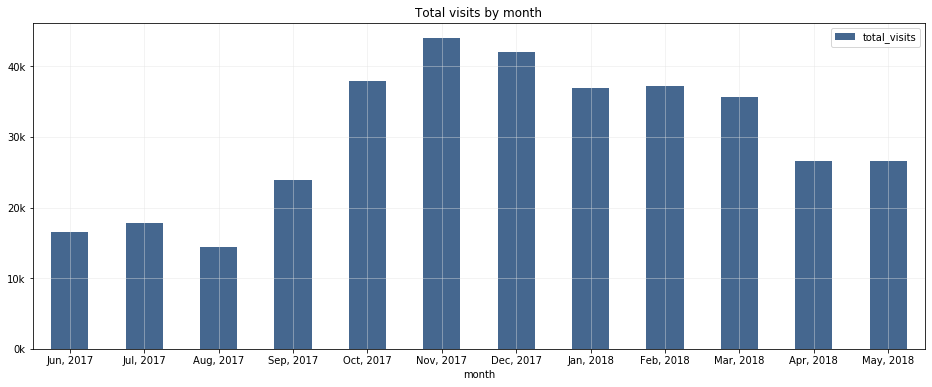

In [17]:
ax = visits_by_month.plot(x='month', y='total_visits', kind='bar', figsize=(16,6),color='#45678f');
ax.set_xticklabels(visits_by_month['month'].dt.strftime('%b, %Y'));
plt.xticks(rotation=0);
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos:'{:.0f}k'.format(y/1000)))
ax.grid(True, color='#e2e2e2', alpha=0.5);
plt.title('Total visits by month');

Данный график дает краткое представление о том, что происходило с визитами на сайт в течение исследуемого периода. Лето 2017 года было очень скудным на посещения, общее количество визитов на сайт за 1 летний месяц не доходило до 20 тыс. Осенью 2017 года количество визитов начало расти и достигло пика в ноябре. После этого ежемесячно мы видим сокращение ежемесячного общего количества посещений сайта, но не ниже уровня лета 2017 года. 

Мы не можем говорить о сезонности только лишь на основании данных за 1 год. Вероятно действительно количество визитов в позднюю весну - лето сокращается, поскольку люди больше времени проводят на открытом воздухе, в отпусках, поездках и меньше интересуются событиями. Но это только предположение, проверить которое мы сможешь лишь при наличии информации за несколько лет.

#### DAU, WAU & MAU

Посчитаем количество уникальных пользователей в день (DAU), неделю (WAU) и месяц (MAU). Для расчета выделим в отдельные столбцы год, месяц и неделю, а также полную дату.

In [18]:
visits['session_year']  = visits['start_ts'].dt.year
visits['session_month'] = visits['start_ts'].dt.month
visits['session_week']  = visits['start_ts'].dt.week
visits['session_date'] = visits['start_ts'].dt.date

In [19]:
#функция для построения графиков dau,wau,mau
def au_count(data,grouping_col,title):
    au = data.groupby(grouping_col).agg({'uid': 'nunique'})
    ax = au.plot(markersize=4, marker='o', figsize=(16,6),color='#45678f');
    plt.title(title);
    plt.ylabel('Number of unique users');
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos:'{:.0f}k'.format(y/1000)))
    ax.grid(True, color='#e2e2e2', alpha=0.5)
    print('Среднее значение {} за период составило: {}'.format(title, int(au.mean())))

Среднее значение DAU за период составило: 907


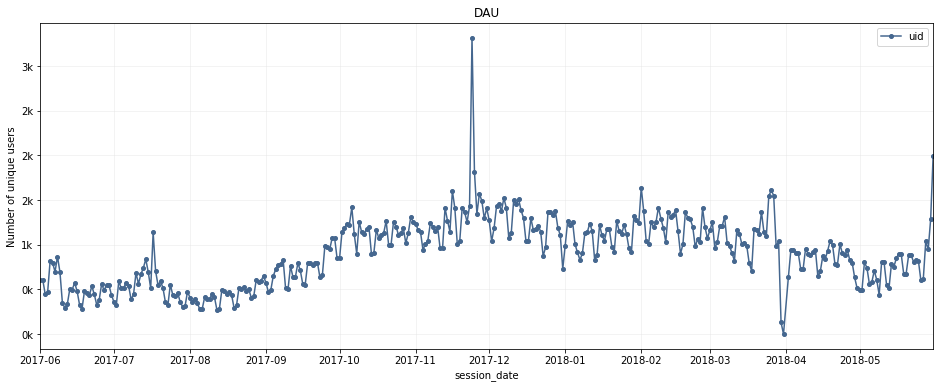

In [20]:
au_count(visits,['session_date'],'DAU')

На графике DAU по дням мы видим много всплесков как в сторону увеличения количества уникальных пользователей, так и в сторону сокращения. Особенно в глаза бросается резкий скачок DAU 24 ноября 2017 года и резкое уменьшение DAU  30-31 марта 2018 года. 

Если скачок вверх до 3319 уникальных пользователей за день вероятно связан с какой-либо рекламной активностью, то снижение количества уникальных пользователей до 1 пользователя 31 марта 2018 года может быть объяснено тем, что на сайте проводились технические работы и он был недоступен.

За весь период средний DAU составляет 907 уникальных пользователей.

Среднее значение WAU за период составило: 5716


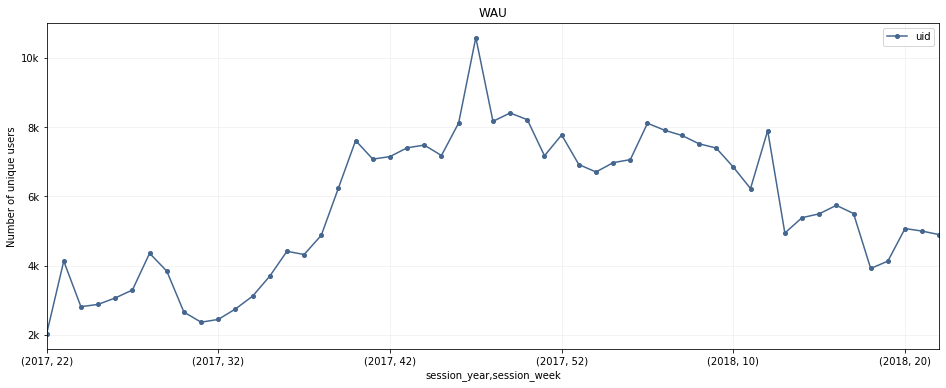

In [21]:
au_count(visits,['session_year','session_week'],'WAU')

На графике DAU мы видим слишком много шумов за счет большого количества дней, график WAU удобнее для поиска каких-либо трендов. Мы по прежнему видим пики в некоторые периоды, можно предположить, что в эти периоды проводились рекламные кампании или открывались продажи на популярные события, что привлекало много пользователей в течение всей недели или бОльшей ее части. 

За весь период средний WAU составляет 5716 уникальных пользователей.

Среднее значение MAU за период составило: 23228


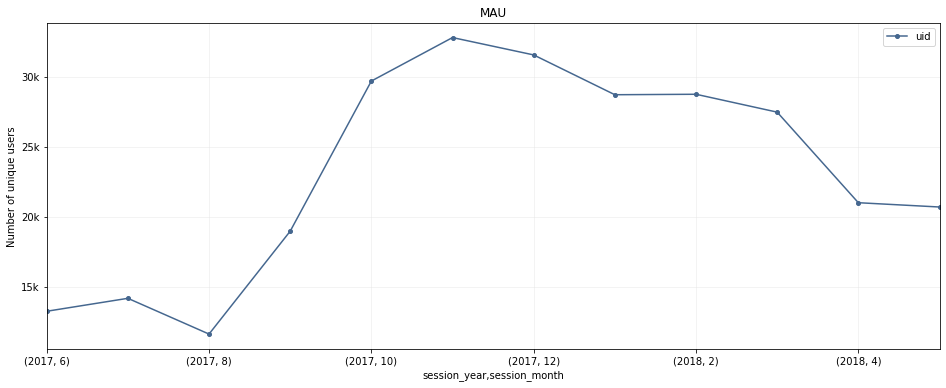

In [22]:
au_count(visits,['session_year','session_month'],'MAU')

График MAU дает общий взгляд на распределение активных пользователей в течение исследуемого периода. Самое низкое значение MAU наблюдалось в августе 2017 года, самое высокое - в ноябре 2017 года. В целом тенденция похожа на ту, что мы наблюдали при анализе общего числа посещений сайта.

За весь период средний MAU составляет 23 228 уникальных пользователей.

Посчитаем показатель sticky factor по отношению к месячной и недельной аудитории:

In [23]:
def sticky_factor(data,monthly=None, weekly=None):
    dau_mean = data.groupby(['session_date']).agg({'uid': 'nunique'}).mean()
    wau_mean = data.groupby(['session_year','session_week']).agg({'uid': 'nunique'}).mean()
    mau_mean = data.groupby(['session_year','session_month']).agg({'uid': 'nunique'}).mean()
    if monthly is None:
        sticky_factor = dau_mean/wau_mean
    else:
        sticky_factor = dau_mean/mau_mean
    return sticky_factor

In [24]:
print('Sticky factor по отношению к месячной аудитории составляет: {:.2%}'.format(float(sticky_factor(visits,monthly=True))))
print('Sticky factor по отношению к недельной аудитории составляет: {:.2%}'.format(float(sticky_factor(visits,weekly=True))))

Sticky factor по отношению к месячной аудитории составляет: 3.91%
Sticky factor по отношению к недельной аудитории составляет: 15.88%


Sticky factor по отношению к месячной аудитории составляет только 4%, достаточно низкое значение показателя.

#### Количество сессий в день и длительность одной сессиии (ASL)

Мы посмотрели на общее количество сессий, на количество уникальных пользователей, теперь посмотрим на количество и продолжительность сессий.

In [25]:
visits_per_user = visits.groupby('session_date').agg({'uid': ['count','nunique']})
visits_per_user.columns = ['n_sessions', 'n_users']
visits_per_user['sessions_per_user'] = visits_per_user['n_sessions'] / visits_per_user['n_users']
print('Среднее количество сессий на 1 уникального юзера в день: {:.2f}'.format(visits_per_user['sessions_per_user'].mean()))

Среднее количество сессий на 1 уникального юзера в день: 1.08


In [26]:
visits_per_user['sessions_per_user'].agg(['mean','median'])

mean      1.082170
median    1.082488
Name: sessions_per_user, dtype: float64

В среднем один уникальный юзер посещает сайт 1 раз в день. Среднее значение количества сессий в день и медиана совпадают, вероятно распределение близко к нормальному, проверим это:

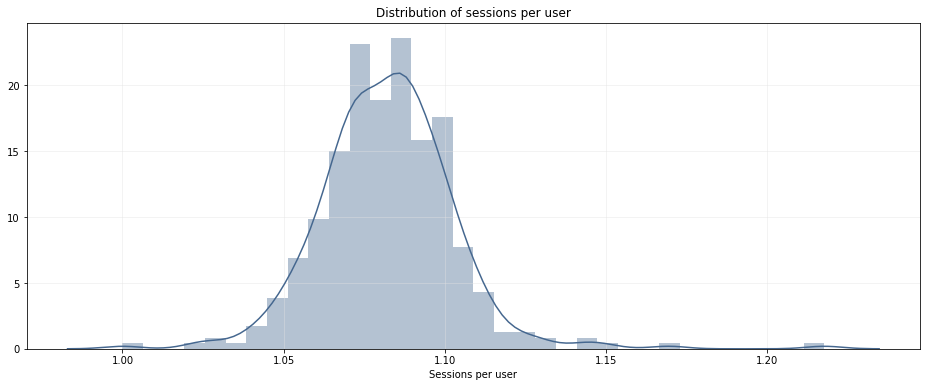

In [27]:
plt.figure(figsize=(16,6))
ax = sns.distplot(visits_per_user['sessions_per_user'],color='#45678f');
plt.title('Distribution of sessions per user');
plt.xlabel('Sessions per user');
ax.grid(True, color='#e2e2e2', alpha=0.5)

Действительно, количество сессий в день на 1 юзера распределяется нормально. Среднее и медиана равны 1.08, а максимальное среднее значение за 1 день составляло 1.2 сессии в день. Таким образом можно сказать, что хотя и есть юзеры, которые посещают сайт более 1 раза в день, тем не менее их количество слишком мало.

Интересно также посмотреть на количество сессий на одного юзера в месяц:

In [28]:
visits_per_user_monthly = visits.groupby(['session_year','session_month']).agg({'uid': ['count','nunique']})
visits_per_user_monthly.columns = ['n_sessions', 'n_users']
visits_per_user_monthly['sessions_per_user'] = visits_per_user_monthly['n_sessions'] / visits_per_user_monthly['n_users']
print('Среднее количество сессий на 1 уникального юзера в месяц: {:.2f}'.format(visits_per_user_monthly['sessions_per_user'].mean()))

Среднее количество сессий на 1 уникального юзера в месяц: 1.28


In [29]:
visits_per_user_monthly['sessions_per_user'].agg(['mean','median'])

mean      1.280889
median    1.281448
Name: sessions_per_user, dtype: float64

In [30]:
visits_per_user_monthly

n_sessions  n_users  sessions_per_user
session_year session_month                                        
2017         6                   16505    13259           1.244815
             7                   17828    14183           1.256998
             8                   14355    11631           1.234202
             9                   23907    18975           1.259921
             10                  37903    29692           1.276539
             11                  43969    32797           1.340641
             12                  41983    31557           1.330386
2018         1                   36939    28716           1.286356
             2                   37182    28749           1.293332
             3                   35679    27473           1.298693
             4                   26515    21008           1.262138
             5                   26635    20701           1.286653

В месяц один пользователь в среднем заходит на сайт 1 раз. Несомненно есть пользователи, которые заходят чаще, однако их доля значительно меньше. Мы видим, что в ноябре-декабре среднее количество сессий на одного пользователя за месяц больше, чем в остальные месяцы и  превышает 1.3 сессии. Самое низкое среднее значение наблюдалось в августе 2017 года.

Посчитаем метрику ASL и узнаем длительность одной сессии:

In [31]:
visits['session_duration_min'] = (visits['end_ts'] - visits['start_ts']).dt.seconds/60

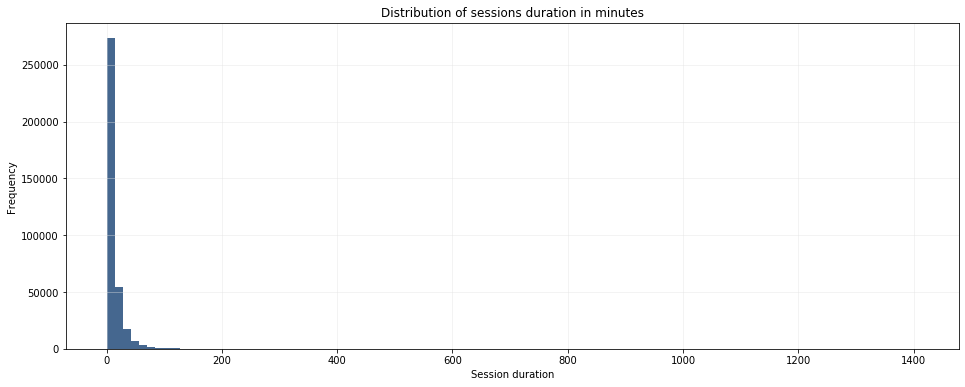

In [32]:
ax = visits['session_duration_min'].plot(kind='hist', bins=100,color='#45678f',figsize=(16,6));
plt.title('Distribution of sessions duration in minutes');
plt.xlabel('Session duration');
ax.grid(True, color='#e2e2e2', alpha=0.5)

In [33]:
visits['session_duration_min'].agg(['mean','median'])

mean      10.725108
median     5.000000
Name: session_duration_min, dtype: float64

In [34]:
visits['session_duration_min'].mode()

0    1.0
dtype: float64

На графике мы видим, что основная доля сессий сосредоточена близко к нулю, однако при этом у распределения очень длинный правый хвост, есть сессии продолжительностью до суток. Необходимо уточнить, что понимается под сессией в Яндекс.Афише, не срабатывает ли автоматическое окончание сессии, если пользователь не совершал какие-либо действия на сайте. Если нет, то такие длинные сессии могут говорить о том, что сайт у пользователя мог находиться в фоновом режиме.

Средняя продолжительности сессии не показательна для нас из-за длинного хвоста. Медиана составляет 5 минут, а мода - 1 минута.

In [35]:
visits[visits['session_duration_min'] < 10]['session_duration_min'].value_counts()

1.000000    53029
0.000000    35794
2.000000    35748
3.000000    26672
4.000000    21085
5.000000    17005
6.000000    14316
7.000000    12301
8.000000    10973
9.000000     9722
0.316667      868
Name: session_duration_min, dtype: int64

Интересно, что длительность сессий принимает в основном только целочисленные значения, на выборке сессий до 10 минут мы видим лишь одно нецелочисленное значение - 0.32 минуты (или 19 секунд). Еще один повод уточнить, что же понимается под сессией и как учитывается старт и окончание сессии в Яндекс.Афише.

#### Retention Rate

Соберем в таблице информацию о первом посещении для каждого уникального пользователя и добавим эту информацию в общую таблицу:

In [36]:
first_activity_date = visits.groupby(['uid'])['start_ts'].min()
first_activity_date.name = 'first_activity_date'

visits = visits.join(first_activity_date,on='uid')

In [37]:
visits['activity_month'] = visits['start_ts'].astype('datetime64[M]').dt.normalize() 
visits['first_activity_month'] = visits['first_activity_date'].astype('datetime64[M]').dt.normalize()

In [38]:
visits.head(5)

,device,end_ts,source_id,start_ts,uid,start_ts_month,session_year,session_month,session_week,session_date,session_duration_min,first_activity_date,activity_month,first_activity_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-01,2017,12,51,2017-12-20,18.0,2017-12-20 17:20:00,2017-12-01,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-01,2018,2,8,2018-02-19,28.0,2018-02-19 16:53:00,2018-02-01,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017,7,26,2017-07-01,0.0,2017-07-01 01:54:00,2017-07-01,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-01,2018,5,20,2018-05-20,24.0,2018-03-09 20:05:00,2018-05-01,2018-03-01
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-01,2017,12,52,2017-12-27,0.0,2017-12-27 14:06:00,2017-12-01,2017-12-01


Добавим столбец cohort_lifetime, в котором посчитаем "месяц жизни" для каждого посещения сайта пользователем. Нулевой месяц - тот, в который пользователь первый раз за период посетил сайт.

In [39]:
visits['cohort_lifetime'] = visits['activity_month'] - visits['first_activity_month']
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1,'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype(int)

Для каждой когорты посчитаем количество пользователей, которые заходили на сайт в тот или иной "месяц жизни":

In [40]:
cohorts = visits.groupby(['first_activity_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
cohorts

,first_activity_month,cohort_lifetime,uid
0,2017-06-01,0,13259
1,2017-06-01,1,1043
2,2017-06-01,2,713
3,2017-06-01,3,814
4,2017-06-01,4,909
...,...,...,...
73,2018-03-01,1,861
74,2018-03-01,2,557
75,2018-04-01,0,15709
76,2018-04-01,1,760


Добавим столбец с изначальным количеством уникальных пользователей в когорте для последующего расчета Retention rate:

In [41]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month','uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})
cohorts = cohorts.merge(initial_users_count, on='first_activity_month')
cohorts

,first_activity_month,cohort_lifetime,uid,cohort_users
0,2017-06-01,0,13259,13259
1,2017-06-01,1,1043,13259
2,2017-06-01,2,713,13259
3,2017-06-01,3,814,13259
4,2017-06-01,4,909,13259
...,...,...,...,...
73,2018-03-01,1,861,20589
74,2018-03-01,2,557,20589
75,2018-04-01,0,15709,15709
76,2018-04-01,1,760,15709


In [42]:
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']

In [43]:
#преобразуем месяц для красивого вывода на графике
cohorts['first_activity_month'] = cohorts['first_activity_month'].dt.strftime('%b, %Y')

In [44]:
retention_pivot = cohorts.pivot_table(index='first_activity_month',columns='cohort_lifetime',values='retention',aggfunc='sum')

In [45]:
def heatmap(data,title,fmt,vmin=None, vmax=None):
    """Функция для построения графиков heatmap. 
    
    Параметры:
    ---------
    data: название датасета        
    title: название графика
    fmt: формат значения в ячейке 
    vmin: опционально, если необходимо изменить минимум на шкале heatmap
    vmax: опционально, если необходимо изменить максимум на шкале heatmap
     """   
    plt.figure(figsize=(14,8))
    data = data.reindex(['Jun, 2017','Jul, 2017','Aug, 2017','Sep, 2017','Oct, 2017','Nov, 2017','Dec, 2017','Jan, 2018','Feb, 2018','Mar, 2018','Apr, 2018','May, 2018'])
    if vmin is None and vmax is None:     
        ax = sns.heatmap(data, annot=True, annot_kws={'size': 12}, fmt=fmt, linewidths=0.5, cmap="BuPu_r");        
    else:
        ax = sns.heatmap(data, annot=True, annot_kws={'size': 12}, fmt=fmt, linewidths=0.5, vmin=vmin,vmax=vmax, cmap="BuPu_r");
    
    plt.ylabel('Cohorts');
    plt.xlabel('Cohort lifetime');
    plt.title(title);

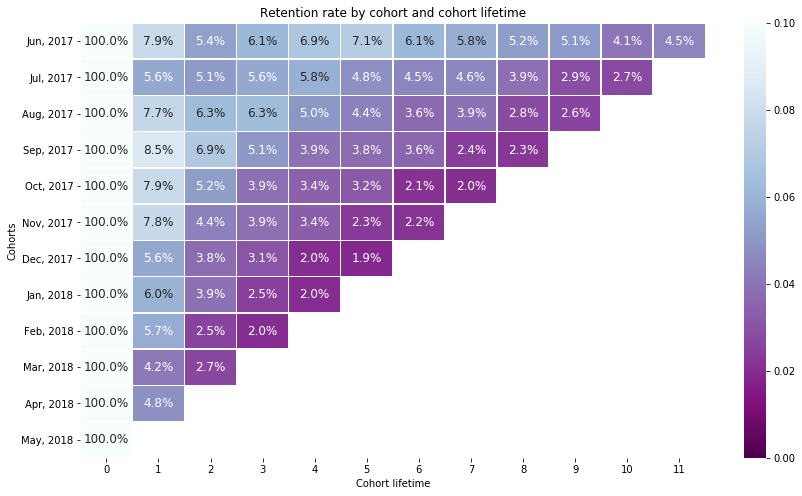

In [46]:
#heatmap(data,title,fmt,vmin=None, vmax=None)
heatmap(retention_pivot,'Retention rate by cohort and cohort lifetime','.1%',0,0.1)

Показатели возвращемости пользователей в последующие месяцы после первого посещения для каждой короты достаточно низкие. Когорта, пользователи которой в первый раз зашли на сайт в июне 2017 года, показывает уровень возвращаемости выше, чем другие когорты.

Вероятно такой низкий показатель возвращаемости говорит о том, что пользователи заходят на сайт только при наличии потребности прочитать отзыв о мероприятии или приобрести билет и реже пользуется сайтом, как блогом. 


## Вывод

В данном шаге мы поставили перед собой задачу ответить на следующие вопросы:

**1)** Сколько людей пользуются в день, неделю, месяц?  
**2)** Сколько сессий в день?  
**3)** Сколько длится одна сессия?  
**4)** Как часто люди возвращаются?  

Ответим на них по порядку.  

 **1)** Сколько людей пользуются в день, неделю, месяц?  
 
 В день среднее количество уникальных пользователей составляло 907 пользователей. За неделю в среднем количество уникалльных пользователей составляло 5716 человек, а за месяц - 23228 человек. 
 
 Фактор липкости (sticky factor) на основании этих значений составлял 4% по отношению к месячной аудитории и 16% по отношению к недельной аудитории. Значение показателя достаточно низкое, что говорит о низкой вовлеченности пользователей.
 
 **2)** Сколько сессий в день?
 
 В среднем один уникальный юзер посещает сайт 1 раз в день. Мы также посмотрели на количество сессий за месяц и получили такой результат: в месяц один пользователь в среднем заходит на сайт 1 раз. Несомненно есть пользователи, которые заходят чаще, однако их доля значительно меньше.
 
 **3)** Сколько длится одна сессия?
 
Медианное значение продолжительности сессии составляет 5 минут, однако мода - значение, которое встречается чаще всего - 1 минута. То есть чаще всего продолжительность посещения сайта составляет одну минуту. Вряд ли за это время пользователь успевает сделать заказ.

**4)** Как часто люди возвращаются? 

Пользователи возвращаются не часто и вероятно лишь по потребности приобрести билет или выбрать мероприятие. Через месяц после первого посещения максимальное значение retention rate составило 8,5% пользователей, для когорты сентября 2017 года, для других когорт возвращаемость составляла от 4,2% (когорта марта 2018) до 7,9%. В последующие месяцы возвращаемость падает. Мы можем заменить некоторые увеличения показателя, в ноябре 2017 года, например, однако сложно объяснить данное явление без дополнительной информации.

## 3.2. Анализ продаж. <a name="3.2step"></a>

В данном шаге проанализируем продажи, ответим на следующие вопросы:

**1)** Когда люди начинают покупать?  
**2)** Сколько раз покупают за период?  
**3)** Какой средний чек?  
**4)** Сколько денег приносят? (LTV)  

Прежде всего посмотрим выручку Яндекс.Афиша за период и проанализируем распределение выручки по месяцам:

In [47]:
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')

In [48]:
orders.groupby('order_month').agg({'revenue':'sum'})

,revenue
order_month,
2017-06-01,9557.49
2017-07-01,12539.47
2017-08-01,8758.78
2017-09-01,18345.51
2017-10-01,27987.70
2017-11-01,27069.93
2017-12-01,36388.60
2018-01-01,19417.13
2018-02-01,25560.54


In [49]:
orders[orders['order_month'] == '2018-06-01']

,buy_ts,revenue,uid,order_month
50414,2018-06-01 00:02:00,3.42,83872787173869366,2018-06-01


Из таблицы видим, что в датасет orders попали данные о выручке за июнь 2018 года, причем попала только одна транзакция. Исключим эту транзакцию из датасета, для дальнейшего анализа она нам не пригодится. 

In [50]:
orders = orders.query('order_month != "2018-06-01"')

In [51]:
orders_by_month = orders.groupby('order_month').agg({'revenue':'sum'}).reset_index()
orders_by_month.columns=['month','revenue']
orders_by_month

,month,revenue
0,2017-06-01,9557.49
1,2017-07-01,12539.47
2,2017-08-01,8758.78
3,2017-09-01,18345.51
4,2017-10-01,27987.70
5,2017-11-01,27069.93
6,2017-12-01,36388.60
7,2018-01-01,19417.13
8,2018-02-01,25560.54
9,2018-03-01,28834.59


In [52]:
print('Всего за период с июня 2017 года по май 2018 года было получена выручка в размере: {:.2f} руб.'.format(orders['revenue'].sum()))

Всего за период с июня 2017 года по май 2018 года было получена выручка в размере: 252053.78 руб.


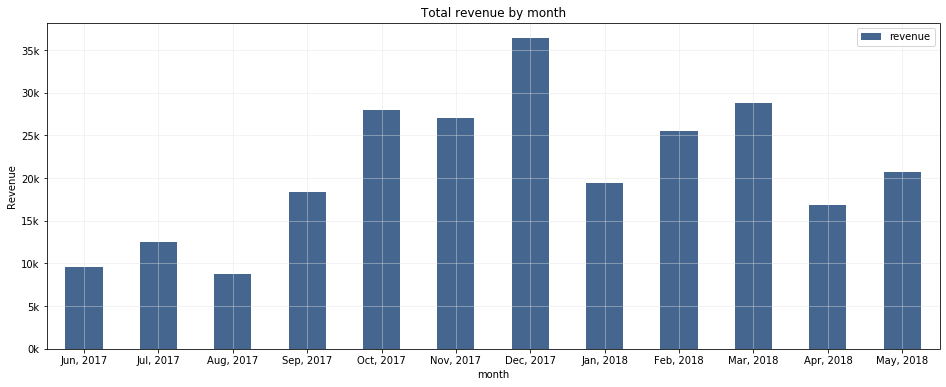

In [53]:
ax = orders_by_month.plot(x='month',y='revenue',kind='bar',figsize=(16,6),color='#45678f');
ax.set_xticklabels(orders_by_month['month'].dt.strftime('%b, %Y'));
plt.xticks(rotation=0);
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos:'{:.0f}k'.format(y/1000)));
ax.grid(True, color='#e2e2e2', alpha=0.5);
plt.title('Total revenue by month');
plt.ylabel('Revenue');

Итак, на графике мы видим, как распределялась выручка за весь период по месяцам. Самым прибыльным месяцем можно считать декабрь 2017 года. Это может быть связано с приобретением на Новый год подарков в виде билетов на мероприятие. Следующий по убыванию - март 2018 года, затем октябрь 2017 года. По аналогии с количеством посещений, самая низкая выручка приходится на лето 2017 года. Кстати о визитах, интересно посмотреть на одном графике, как ведет себя выручка и посещения по месяцам, есть ли между ними какая-то зависимость:

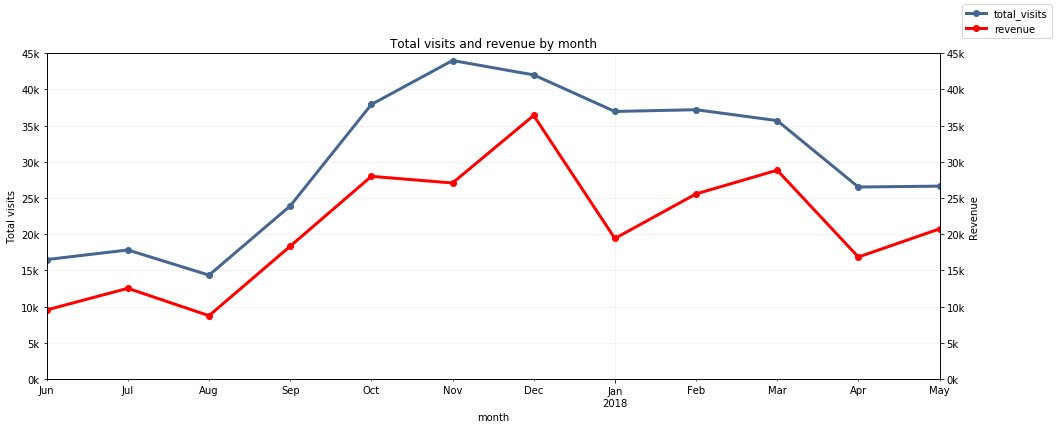

In [54]:
ax = visits_by_month.plot(x='month', y='total_visits', figsize=(16,6), legend=False, linewidth=3,markersize=6, marker='o',color='#45678f');
ax2 = ax.twinx()
orders_by_month.plot(x='month',y='revenue',figsize=(16,6),ax=ax2,color="r", legend=False, linewidth=3,markersize=6, marker='o');

ax.set_ylim(0,45000)
ax2.set_ylim(0,45000)
ax.figure.legend(loc='best')
ax.set_ylabel('Total visits')
ax2.set_ylabel('Revenue');
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, p: '{:.0f}k'.format(y/1000)))
ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, p: '{:.0f}k'.format(y/1000)))
ax.grid(True, color='#e2e2e2', alpha=0.5)
plt.title('Total visits and revenue by month');

До октября графики количества посещений и выручки ведут себя одинаково, затем картина меняется. К ноябрю растет количество визитов, но падает выручка, а в декабре ситуация обратная. В январе выручка сокращается сильнее, чем количество визитов (подарки уже были куплены в декабре, а в январе денег мало).

Для каждого уникального пользователя найдем дату первой покупки и присоедим полученную информацию к основной таблице orders:

In [55]:
first_order_date = orders.groupby('uid')['buy_ts'].min()
first_order_date.name = 'first_order_date'
orders = orders.join(first_order_date,on='uid')

In [56]:
orders['first_order_month'] = orders['first_order_date'].astype('datetime64[M]').dt.normalize()
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]').dt.normalize()

Добавим столбец cohort_lifetime, в котором посчитаем "месяц жизни" для каждой покупки пользователя. Нулевой месяц - тот, в который пользователь первый раз сделал покупку на сайте.

In [57]:
orders['cohort_lifetime'] = orders['order_month'] - orders['first_order_month']
orders['cohort_lifetime'] = orders['cohort_lifetime'] / np.timedelta64(1,'M')
orders['cohort_lifetime'] = orders['cohort_lifetime'].round().astype('int')

Для каждой когорты посчитаем количество уникальных пользователей в каждый из "месяцев жизни", количество покупок, сумму выручки за период, накопленную выручку за период. Затем добавим к полученной таблицы изначальное количество пользователей (в 0 lifetime), будем использовать это для расчета LTV.

In [58]:
buy_cohorts = orders.groupby(['first_order_month','cohort_lifetime']).agg({'uid':'nunique','buy_ts':'count','revenue':'sum'}).reset_index()
buy_cohorts['cumulative_revenue'] = buy_cohorts.groupby('first_order_month')['revenue'].cumsum()

In [59]:
buy_cohort_users = buy_cohorts[buy_cohorts['cohort_lifetime'] == 0][['first_order_month','uid']]
buy_cohort_users = buy_cohort_users.rename(columns={'uid':'cohort_users'})
buy_cohorts = buy_cohorts.merge(buy_cohort_users, on='first_order_month')
buy_cohorts.head(5)

,first_order_month,cohort_lifetime,uid,buy_ts,revenue,cumulative_revenue,cohort_users
0,2017-06-01,0,2023,2354,9557.49,9557.49,2023
1,2017-06-01,1,61,177,981.82,10539.31,2023
2,2017-06-01,2,50,174,885.34,11424.65,2023
3,2017-06-01,3,54,226,1931.30,13355.95,2023
4,2017-06-01,4,88,292,2068.58,15424.53,2023


Посмотрим на графике, сколько каждая из когорт приносила выручки в тот или иной месяц жизни:

In [60]:
buy_cohorts_pivot = buy_cohorts.pivot_table(
                                index='first_order_month',columns='cohort_lifetime',
                                values='revenue',aggfunc='sum')

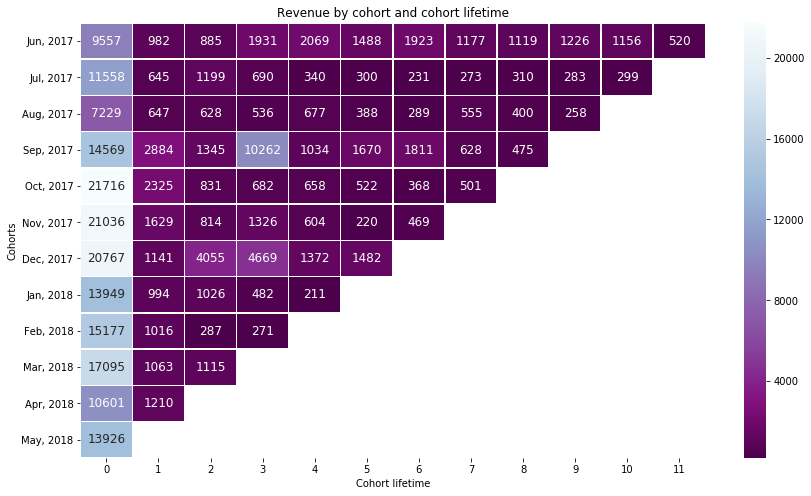

In [61]:
#heatmap(data,title,fmt,vmin=None, vmax=None)
heatmap(buy_cohorts_pivot,'Revenue by cohort and cohort lifetime','.0f')

Во всех когортах явно заметна тенденция на сокращение прибыли с течением времени. Мы видим некоторые увеличения прибыли, но они имеют локальный характер у определенных когорт, а не у всех когорт одновременно. 

На графике распределения выручки по месяцам мы видели, что пик приходится на декабрь, однако если мы посмотрим по когортам, то можно заметить, что пик в декабре обеспечивает одна когорта - сентября 2017 года. Для всех остальных когорт декабрь проходит практически бесследно, заметного увеличения выручки не наблюдается.

Построим график по кумулятивной выручке по когортам 7 месяцев 2017 года, поскольку для них есть данные минимум за полгода: 

In [62]:
buy_cohorts_pivot_cumulative = buy_cohorts.pivot_table(
                                index='first_order_month',columns='cohort_lifetime',
                                values='cumulative_revenue',aggfunc='sum')
buy_cohorts_pivot_cumulative = buy_cohorts_pivot_cumulative\
                                .reindex(['Jun, 2017','Jul, 2017','Aug, 2017','Sep, 2017','Oct, 2017','Nov, 2017','Dec, 2017','Jan, 2018','Feb, 2018','Mar, 2018','Apr, 2018','May, 2018'])

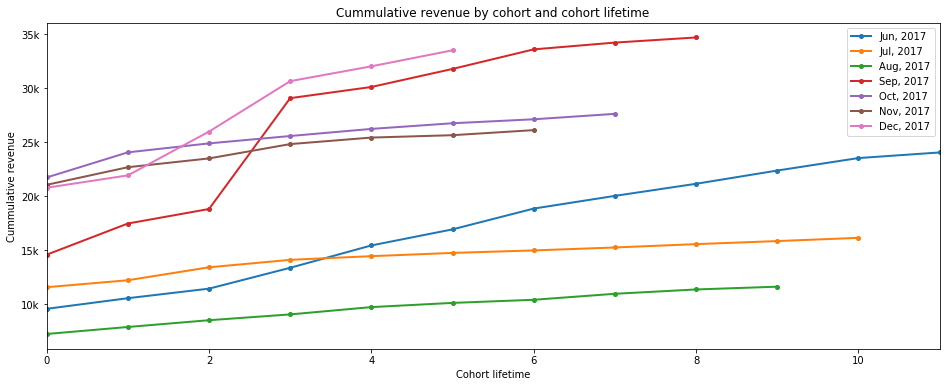

In [63]:
for first_activity_month in buy_cohorts_pivot_cumulative.index:
    if '2017' in first_activity_month:
        ax = buy_cohorts_pivot_cumulative.loc[(first_activity_month)].plot(figsize=(16,6),linewidth=2,markersize=4, marker='o');
        plt.legend();
        plt.title('Cummulative revenue by cohort and cohort lifetime');
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, p: '{:.0f}k'.format(y/1000)))
        plt.ylabel('Cummulative revenue');
        plt.xlabel('Cohort lifetime');

Накопленная выручка всех когорт, за исключением когорты сентября 2017 года и декабря 2017 года, выглядят примерно одинаково: без неожиданных пиков, гладкий рост, прирост между каждым следующим месяцем жизни становится все меньше.

Когорта сентября 2017 года имеет резкий скачок за счет высокой выручки в декабре 2017 года, а когорта декабря - за счет февраля и марта 2018 года. Однако после этих скачков следует такой же гладкий рост, как и по другим когортам.


#### Первая покупка

Посмотрим, сколько в среднем проходит времени между первым посещением сайта и первой покупкой. Ранее мы уже находили дату первой активности (не покупки!) для каждого пользователя. Воспользуемся вновь данной информацией, добавим к ней столбец с месяцем и объединим с информацией о заказах по номеру uid:

In [64]:
first_activity_date = first_activity_date.reset_index()
first_activity_date['first_activity_month'] = first_activity_date['first_activity_date'].astype('datetime64[M]')

orders = orders.merge(first_activity_date, on='uid',how='left')

Проверим, что количество строк в датасете не изменилось, изначально в датасете было 50415 строк:

In [65]:
orders.shape

(50414, 9)

Сгруппируем в таблицу информацию о дате и времени первой покупки и дате и времени первого посещения для каждого пользователя, посчитаем разницу между ними в минутах:

In [66]:
first_buy = orders.groupby(['uid','first_order_date','first_activity_date'])['revenue'].sum().reset_index()
first_buy['first_buy_diff_min'] = first_buy['first_order_date'] - first_buy['first_activity_date']
first_buy['first_buy_diff_min']= (first_buy['first_buy_diff_min'].dt.total_seconds())/60
first_buy

,uid,first_order_date,first_activity_date,revenue,first_buy_diff_min
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00,0.55,154022.0
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,3.05,0.0
2,2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00,73.33,79.0
3,2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00,2.44,1184.0
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,10.99,0.0
...,...,...,...,...,...
36517,18445147675727495770,2017-11-24 09:03:00,2017-08-20 13:30:00,3.05,137973.0
36518,18445407535914413204,2017-09-22 23:55:00,2017-09-22 23:48:00,0.88,7.0
36519,18445601152732270159,2018-03-26 22:54:00,2017-08-07 11:51:00,4.22,333303.0
36520,18446156210226471712,2018-02-18 19:34:00,2017-11-07 10:01:00,9.78,148893.0


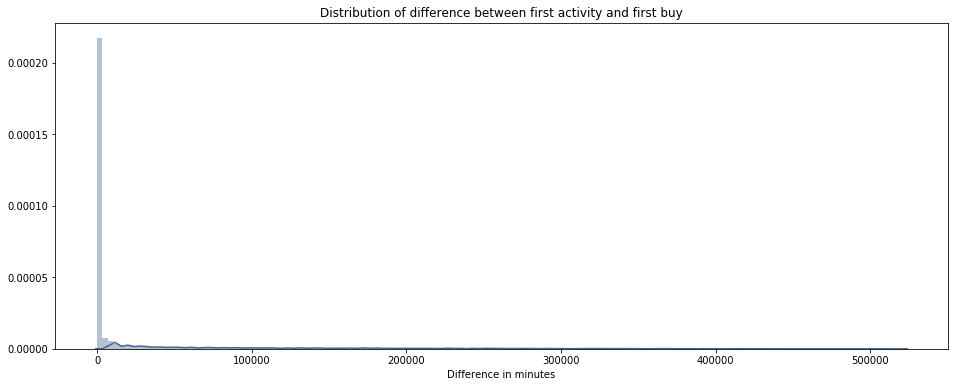

In [67]:
plt.figure(figsize=(16,6));
sns.distplot(first_buy['first_buy_diff_min'],color='#45678f', bins=150);
plt.title('Distribution of difference between first activity and first buy');
plt.xlabel('Difference in minutes');

График распределения имеет длинный правый хвост, но основная доля сосредоточена ближе к 0. Такой график не очень информативен из-за наличия очень больших значений. Воспользуемся методом describe, также посмотрим на диаграмму размаха:

In [68]:
first_buy['first_buy_diff_min'].describe()

count     36522.000000
mean      24340.842205
std       67785.583078
min           0.000000
25%           4.000000
50%          16.000000
75%        2897.500000
max      523144.000000
Name: first_buy_diff_min, dtype: float64

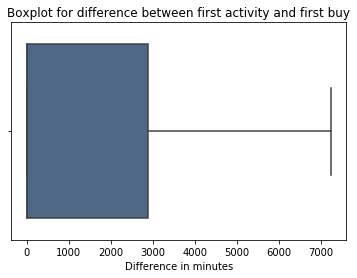

In [69]:
sns.boxplot(first_buy['first_buy_diff_min'], showfliers=False,color='#45678f');
plt.title('Boxplot for difference between first activity and first buy');
plt.xlabel('Difference in minutes');

In [70]:
q1 = first_buy['first_buy_diff_min'].describe()['25%']
q3 = first_buy['first_buy_diff_min'].describe()['75%']
iqr = (q3 - q1)
print('Граница диаграммы размаха справа равна:', q3 + 1.5*iqr)

Граница диаграммы размаха справа равна: 7237.75


In [71]:
print('Количество пользователей, первая покупка которых произошла позднее, чем через 7238 минут (5 дней):',\
      first_buy[first_buy['first_buy_diff_min'] > q3 + 1.5*iqr].shape[0])
print('Доля таких пользователей в общем количестве пользователей: {:.0%}'\
     .format(first_buy[first_buy['first_buy_diff_min'] > q3 + 1.5*iqr].shape[0] / first_buy.shape[0]))

Количество пользователей, первая покупка которых произошла позднее, чем через 7238 минут (5 дней): 7809
Доля таких пользователей в общем количестве пользователей: 21%


Среднее значение составляет 24341 минуту, что составляет около 17 дней. Однако медианное значение составляет 16 минут. 
Если мы посмотрим на диаграмму размаха, то увидим, что правая ее граница находится на уровне 7238 минут (5 дней). Количество пользователей, первая покупка которых произошла позднее, чем через 5 дней составляет 21%.


#### Количество покупок за период

In [72]:
n_orders_by_month = orders.groupby('first_order_month')['buy_ts'].count().reset_index()
n_orders_by_month.columns = ['month','n_orders']
n_orders_by_month

,month,n_orders
0,2017-06-01,4438
1,2017-07-01,2910
2,2017-08-01,2188
3,2017-09-01,3878
4,2017-10-01,6005
5,2017-11-01,5900
6,2017-12-01,5894
7,2018-01-01,4308
8,2018-02-01,4470
9,2018-03-01,4484


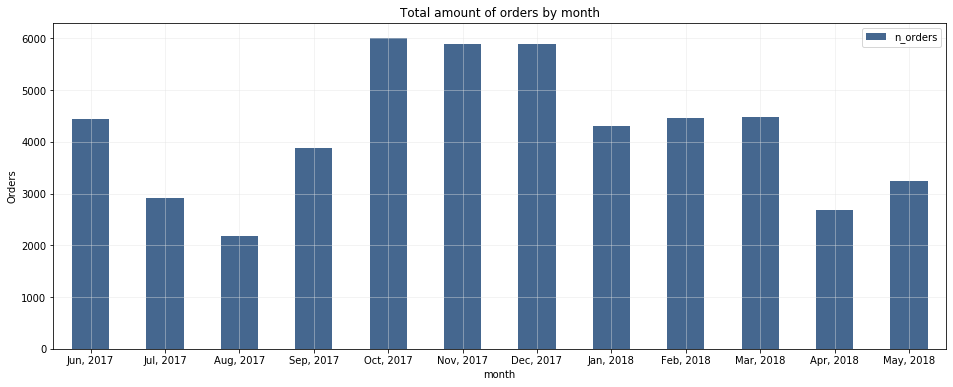

In [73]:
ax = n_orders_by_month.plot(x='month',y='n_orders',kind='bar',figsize=(16,6),color='#45678f');
ax.set_xticklabels(n_orders_by_month['month'].dt.strftime('%b, %Y'));
plt.xticks(rotation=0);
ax.grid(True, color='#e2e2e2', alpha=0.5);
plt.title('Total amount of orders by month');
plt.ylabel('Orders');

Самыми "богатыми" месяцами по количеству заказов являются октябрь - декабрь 2017 года. Самое низкое количество заказов было зафиксировано в августе.

Ообогатим нашу таблицу по ежемесячной выручке, созданной ранее, количеством заказов, затем посчитаем среднюю стоимость заказа в каждом из месяцев.

In [74]:
orders_by_month = orders_by_month.merge(n_orders_by_month, on='month')
orders_by_month['average_price'] = orders_by_month['revenue'] / orders_by_month['n_orders']

In [75]:
orders_by_month

,month,revenue,n_orders,average_price
0,2017-06-01,9557.49,4438,2.153558
1,2017-07-01,12539.47,2910,4.309096
2,2017-08-01,8758.78,2188,4.003099
3,2017-09-01,18345.51,3878,4.730663
4,2017-10-01,27987.70,6005,4.660733
5,2017-11-01,27069.93,5900,4.588124
6,2017-12-01,36388.60,5894,6.173838
7,2018-01-01,19417.13,4308,4.507226
8,2018-02-01,25560.54,4470,5.718242
9,2018-03-01,28834.59,4484,6.430551


Построим график, на котором отбразим одновременно выручку по месяцам и среднюю стоимость 1 заказа:

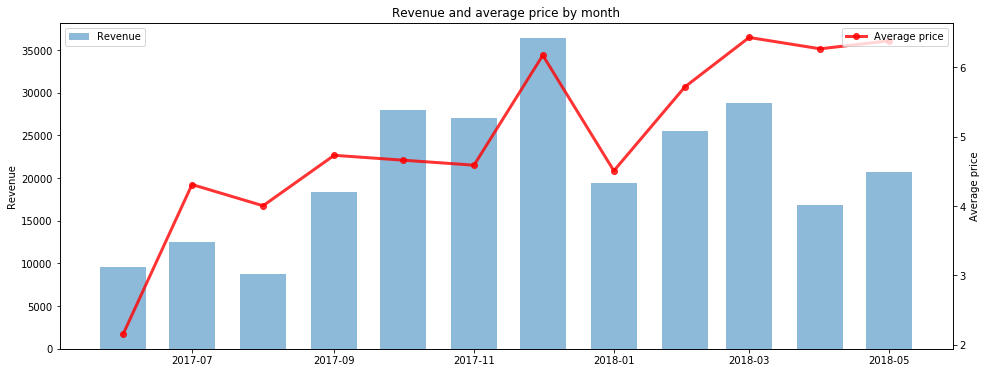

In [76]:
fig, ax1 = plt.subplots(figsize=(16,6))
ax2 = ax1.twinx() 
ax1.set_xticklabels(orders_by_month['month'].dt.strftime('%b, %Y'));
ax1.bar(orders_by_month['month'],orders_by_month['revenue'],width=20, alpha=0.5);
ax2.plot(orders_by_month['month'],orders_by_month['average_price'],linewidth=3,markersize=6, marker='o', color='r', alpha=0.8);
ax1.set_ylabel('Revenue');
ax2.set_ylabel('Average price');
ax1.set_title('Revenue and average price by month');
ax1.legend(['Revenue'], loc='upper left');
ax2.legend(['Average price'], loc='upper right');

В целом график средней цены на 1 заказ повторяет динамику выручки, но есть исключения. Так, например, в октябре 2017 года выручка увеличилась на 34% по сравнению с сентябрем 2017 года, однако средняя цена на 1 заказ даже немного сократилась. 

В марте - мае 2018 года средняя цена 1 заказа самая высокая за исследуемый период, при этом уровень выручки в этот период, особенно в апреле и мае почти в 2 раза меньше, чем в декабре 2017 года.

Посмотрим, как распределялись заказы по когортам:

In [77]:
buy_cohorts.columns = ['first_order_month', 'cohort_lifetime', 'uid', 'n_orders', 'revenue',
       'cumulative_revenue', 'cohort_users']
buy_cohorts.head(5)

,first_order_month,cohort_lifetime,uid,n_orders,revenue,cumulative_revenue,cohort_users
0,2017-06-01,0,2023,2354,9557.49,9557.49,2023
1,2017-06-01,1,61,177,981.82,10539.31,2023
2,2017-06-01,2,50,174,885.34,11424.65,2023
3,2017-06-01,3,54,226,1931.30,13355.95,2023
4,2017-06-01,4,88,292,2068.58,15424.53,2023


In [78]:
number_of_orders = buy_cohorts.pivot_table(
                                index='first_order_month',
                                columns='cohort_lifetime',
                                values='n_orders',
                                aggfunc='sum'
)

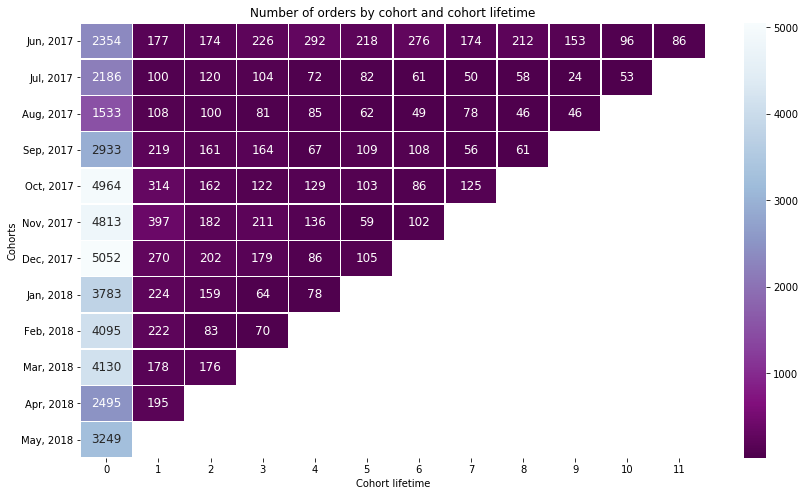

In [79]:
#heatmap(data,title,fmt,vmin=None, vmax=None)
heatmap(number_of_orders,'Number of orders by cohort and cohort lifetime','.0f')

Судя по графику пользователи каждой когорты сделали большую часть заказов в первом же месяце жизни когорты (0-й lifetime) и затем возвращались для заказов очень редко. В целом результат не удивляет, если вспомнить retention rate на сайте. Пользователи редко возвращаются на сайт и редко делают покупки. 

Посчитаем среднюю за каждый месяц жизни:

In [80]:
number_of_orders.mean()

cohort_lifetime
0     3465.583333
1      218.545455
2      151.900000
3      135.666667
4      118.125000
5      105.428571
6      113.666667
7       96.600000
8       94.250000
9       74.333333
10      74.500000
11      86.000000
dtype: float64

Почти 3,5 тысячи заказов в среднем в нулевой месяц и в следующий же месяц мы видим резкое сокращение в среднем до 219 заказов, за которым следует практически ежемесячное сокращение.

Посмотрим, сколько заказов делает 1 пользователь в когорте в разные месяцы жизни:

In [81]:
buy_cohorts['orders_per_user'] = buy_cohorts['n_orders']/buy_cohorts['uid']

In [82]:
orders_per_user = buy_cohorts.pivot_table(
                                index='first_order_month',
                                columns='cohort_lifetime',
                                values='orders_per_user',
                                aggfunc='sum'
)

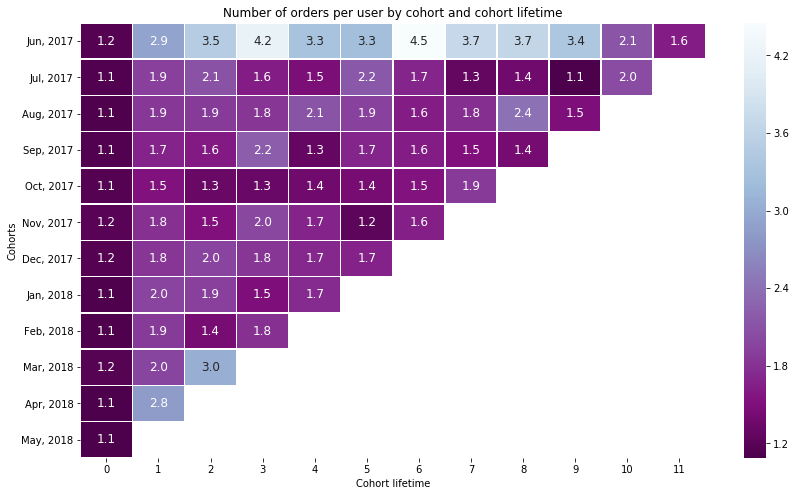

In [83]:
#heatmap(data,title,fmt,vmin=None, vmax=None)
heatmap(orders_per_user,'Number of orders per user by cohort and cohort lifetime','.1f')

#### Средний чек

Выше мы уже посчитали средний чек по месяцам для всех заказов, теперь посчитаем средний чек по когортам:

In [84]:
buy_cohorts['average_price'] = buy_cohorts['revenue'] / buy_cohorts['n_orders']

In [85]:
average_price = buy_cohorts.pivot_table(
                                index='first_order_month',
                                columns='cohort_lifetime',
                                values='average_price',
                                aggfunc='mean'
)

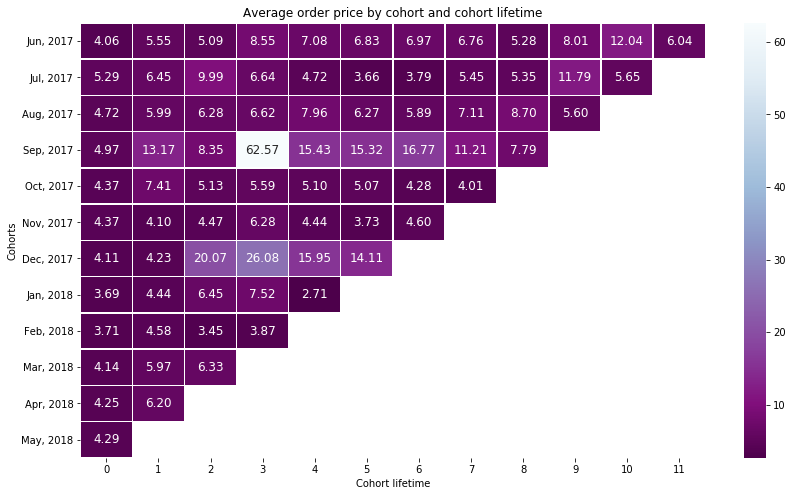

In [86]:
#heatmap(data,title,fmt,vmin=None, vmax=None)
heatmap(average_price,'Average order price by cohort and cohort lifetime','.2f')

В нулевой месяц жизни (месяц первой покупки) для каждой из когорт мы наблюдали самую высокую выручку, самое большое количество заказов, но когда мы рассчитали среднюю стоимость 1 заказа, то стало видно, что средняя цена в нулевой месяц не выделяется на фоне остальных месяцев.

На графике мы видим яркие точки, которые уже замечали ранее: когорта сентября 2017 года с покупками в декабре 2017 года, когорта декабря 2017 года с покупками в феврале и марте 2018 года. Интересно, почему именно эти когорты возвращались в эти месяцы, а остальные - нет, однако мы не сможем ответить на этот вопрос без дополнительной информации.

#### LTV

Итак, подошли к важному вопросу, сколько же денег нам приносят наши пользователи?

In [87]:
buy_cohorts['ltv'] = buy_cohorts['revenue'] / buy_cohorts['cohort_users']

ltv_pivot = buy_cohorts.pivot_table(
                        index='first_order_month',
                        columns='cohort_lifetime',
                        values='ltv',
                        aggfunc='mean'
).round(2)

ltv_pivot = ltv_pivot.cumsum(axis=1)
ltv_pivot.fillna('')

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.72,5.21,5.65,6.6,7.62,8.36,9.31,9.89,10.44,11.05,11.62,11.88
2017-07-01,6.01,6.35,6.97,7.33,7.51,7.67,7.79,7.93,8.09,8.24,8.4,
2017-08-01,5.28,5.75,6.21,6.6,7.09,7.37,7.58,7.99,8.28,8.47,,
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.43,,,
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,,,,
2017-11-01,5.15,5.55,5.75,6.07,6.22,6.27,6.38,,,,,
2017-12-01,4.74,5,5.93,7,7.31,7.65,,,,,,
2018-01-01,4.14,4.43,4.73,4.87,4.93,,,,,,,
2018-02-01,4.16,4.44,4.52,4.59,,,,,,,,


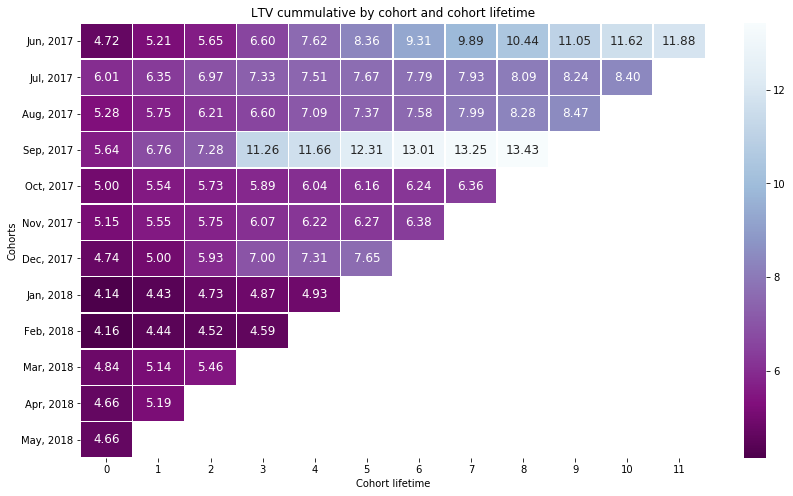

In [88]:
#heatmap(data,title,fmt,vmin=None, vmax=None)
heatmap(ltv_pivot,'LTV cummulative by cohort and cohort lifetime','.2f')

Какие выводы по LTV мы можем сделать:  
* один пользователь когорты июня 2017 года за 12 месяцев принес выручку в размере 11.88 рублей. Однако эта когорта скорее исключение, так как следующие когорты июля и августа 2017 года за 10 месяцев принесли выручку в размере 8.24 и 8.47, соответственно, тогда как когорта июня за 10 месяцев принесла 11.05 на одного пользователя

* при этом один пользователь когорты сентября 2017 года принес за 8 месяцев выручку в размере 13.43 рублей, такое заметное увеличение связано с очень высокой выручкой у этой когорты в декабре 2018 года



Интересно посчитать средний LTV за определенный срок, но мы не сможем это сделать для всех когорт, поскольку у нас есть когорты, которые прожили только 1-2 месяца. Возьмем когорты 2017го года, у нас есть 7 когорт. Посчитаем, сколько выручки приносил в среднем 1 пользователь этих когорт за 6 месяцев (0й - 5й lifetime):

In [89]:
mean_ltv = ltv_pivot.unstack().reset_index()
mean_ltv.columns = ['cohort_lifetime','first_order_month','ltv_cum']

In [90]:
mean_ltv.query('cohort_lifetime == (0,1,2,3,4,5)\
               and first_order_month ==\
               ("2017-06-01","2017-07-01","2017-08-01","2017-09-01","2017-10-01","2017-11-01","2017-12-01")').groupby('cohort_lifetime')['ltv_cum'].mean()

cohort_lifetime
0    5.220000
1    5.737143
2    6.217143
3    7.250000
4    7.635714
5    7.970000
Name: ltv_cum, dtype: float64

К шестому месяцу жизни средняя выручка пользователей, первый раз совершивших покупку в июне-декабре 2017 года составила 7.97 рублей.

## Вывод

Итак, ответим на поставленные в начале шага вопросы:

**1)** Когда люди начинают покупать?  

Промежуток между первым посещением и первой покупкой очень разнится для пользователей. Среднее значение составляет 24341 минуту, что составляет около 17 дней. Однако такое большое среднее значение связано с наличием пользователей с большим промежутком времени. Медианное значение составляет 16 минут, 50% наших пользователей делает первую покупку в промежуток до 16 минут. 
Количество пользователей, первая покупка которых произошла позднее, чем через 5 дней составляет 21%.

**2)** Сколько раз покупают за период?  

82% всех заказов было сделано с первый же месяц покупки. Повторно за заказами приходит небольшое количество пользователей. Однако если в первый месяц в среднем один пользователь делает один заказ, то в последующие месяцы пользователи делают больше заказов - до 3-4 в некоторых когортах. Вероятно возвращаются лояльные пользователи, которые активно посещают мероприятия и предпочитаю покупать билеты на Яндекс.Афише.

**3)** Какой средний чек?  

Средний чек варьируется по месяцам и по когортам. Средний чек за весь период по всем когортам составлят 5 руб. 

**4)** Сколько денег приносят? (LTV)  

За 6 месяцев средняя выручка пользователей, первый раз совершивших покупку в июне-декабре 2017 года составила 7.97 рублей.

## 3.3. Анализ маркетинговых затрат. <a name="3.3step"></a>

В последнем шаге проанализируем маркетинговые расходы и ответим на вопросы:

**1)** Сколько денег потратили? Всего / на каждый источник / по времени  
**2)** Сколько стоило привлечение одного покупателя из каждого источника?  
**3)** На сколько окупились расходы? (ROI)

#### Обзор расходов

In [91]:
print('Всего за период с июня 2017 года по май 2018 года было потрачено: {} руб.'.format(costs['costs'].sum()))

Всего за период с июня 2017 года по май 2018 года было потрачено: 329131.62 руб.


Добавим информацию о месяцах и построим график помесячных расходов:

In [92]:
costs['month'] = costs['dt'].astype('datetime64[M]').dt.normalize()

In [93]:
costs_by_month = costs.groupby(['month'])['costs'].sum().reset_index()

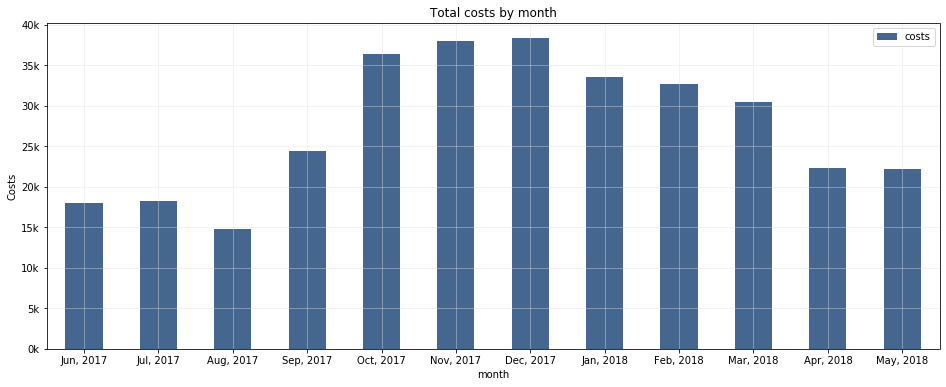

In [94]:
ax = costs_by_month.plot(x='month',y='costs',kind='bar',figsize=(16,6),color='#45678f');
ax.set_xticklabels(costs_by_month['month'].dt.strftime('%b, %Y'));
plt.xticks(rotation=0);
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos:'{:.0f}k'.format(y/1000)));
ax.grid(True, color='#e2e2e2', alpha=0.5);
plt.title('Total costs by month');
plt.ylabel('Costs');

Основная доля расходов была понесена в период с октября по декабрь 2017 года, летом 2017 года расходы были самые низкие за исследуемый период. В целом график расходов выглядит похожим на график выручки по тому, в каких месяцах мы наблюдаем пики, а в каких - низкие значения. Интересно будет сравнить выручку и расходы на одном графике:

In [95]:
orders_by_month['revenue_cum'] = orders_by_month['revenue'].cumsum()
costs_by_month['costs_cum'] = costs_by_month['costs'].cumsum()
costs_by_month = costs_by_month.merge(orders_by_month[['month','revenue_cum']],on='month')
costs_by_month

,month,costs,costs_cum,revenue_cum
0,2017-06-01,18015.00,18015.00,9557.49
1,2017-07-01,18240.59,36255.59,22096.96
2,2017-08-01,14790.54,51046.13,30855.74
3,2017-09-01,24368.91,75415.04,49201.25
4,2017-10-01,36322.88,111737.92,77188.95
5,2017-11-01,37907.88,149645.80,104258.88
6,2017-12-01,38315.35,187961.15,140647.48
7,2018-01-01,33518.52,221479.67,160064.61
8,2018-02-01,32723.03,254202.70,185625.15
9,2018-03-01,30415.27,284617.97,214459.74


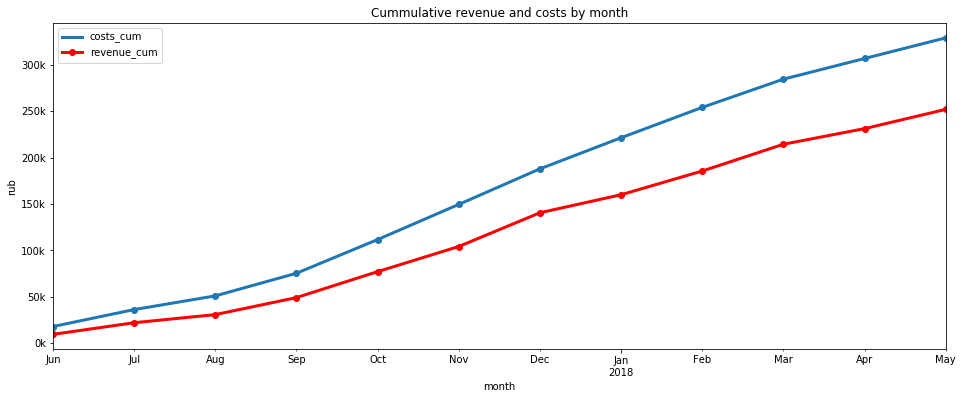

In [96]:
ax = costs_by_month.plot(x='month',y='costs_cum',linewidth=3,markersize=6, marker='o',figsize=(16,6));
costs_by_month.plot(x='month',y='revenue_cum',linewidth=3,markersize=6, marker='o', color='r', ax=ax);
ax1.set_xticklabels(costs_by_month['month'].dt.strftime('%b, %Y'));
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos:'{:.0f}k'.format(y/1000)));
plt.title('Cummulative revenue and costs by month');
plt.ylabel('rub');

На протяжении всего исследуемого периода (год) сумма накопленных расходов превышает сумму выручки. Разница между выручкой и маркетинговыми расходами за год будет отрицательной, то есть мы говорим об убыточном продукте.

Посмотрим, как распределялись маркетинговые затраты по источникам:

In [97]:
(costs.groupby(['month','source_id'])['costs']
          .sum()
          .unstack()
          .apply(lambda x: x*100/sum(x), axis=1)).mean().sort_values(ascending=False)

source_id
3     42.725954
4     18.921547
5     15.671226
2     12.941733
1      6.308963
10     1.761428
9      1.669149
dtype: float64

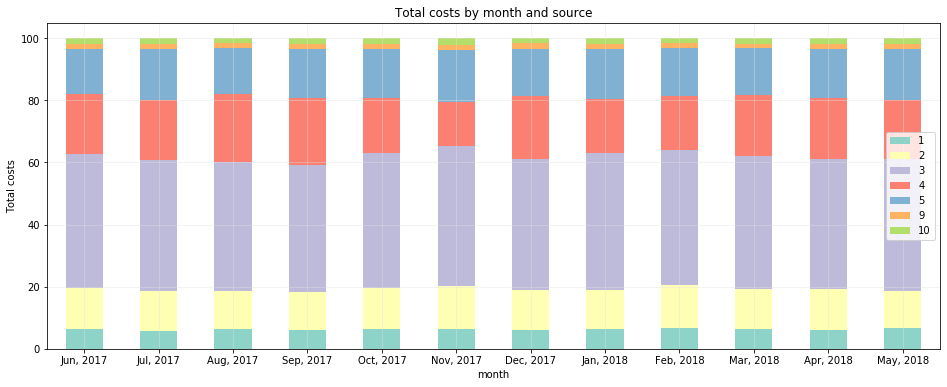

In [98]:
pal = sns.color_palette("Set3")
ax = (costs.groupby(['month','source_id'])['costs']
          .sum()
          .unstack()
          .apply(lambda x: x*100/sum(x), axis=1)
          .plot(kind='bar',stacked=True, figsize=(16,6), colors=pal)
     ) ;
ax.grid(True, color='#e2e2e2', alpha=0.5);
plt.title('Total costs by month and source');
plt.ylabel('Total costs');
plt.legend();
ax.set_xticklabels(['Jun, 2017','Jul, 2017','Aug, 2017','Sep, 2017','Oct, 2017','Nov, 2017','Dec, 2017','Jan, 2018','Feb, 2018','Mar, 2018','Apr, 2018','May, 2018']);
plt.xticks(rotation=0);

Больше всего расходов было потрачено на источник 3, в среднем 43% за все 12 месяцев. Следующий по убыванию источник под номером 4 - 19%, затем следует источник под номером 5 - 15.7%. Ежемесячно структура расходов по источникам существенно не изменялась.

#### Стоимость привлечения одного покупателя

Информация о том, откуда к нам приходят пользователи, имеется в датасете visits. Вероятно один пользователь мог прийти из разных источников, проверим это:

In [99]:
visits.groupby('uid')['source_id'].nunique().sort_values(ascending=False)

uid
1242922364974949363     7
17030528792926543083    7
5603453646174104178     7
8667719997796727944     7
14481163132396345939    7
                       ..
11731632440555246055    1
11731538822080018399    1
11731363928319253464    1
11731261366732678012    1
11863502262781          1
Name: source_id, Length: 228169, dtype: int64

Действительно, есть пользователи, которые пришли из разных рекламных источников. Для последующего анализа мы будем использовать источник, с которого пользователь пришел в первый раз.

In [100]:
users = (visits.sort_values(by = ['uid', 'start_ts']).groupby('uid')
               .agg({'start_ts' : 'first', 'source_id': 'first', 'device': 'first'})
        ).reset_index()
users.head(5)

,uid,start_ts,source_id,device
0,11863502262781,2018-03-01 17:27:00,3,touch
1,49537067089222,2018-02-06 15:55:00,2,touch
2,297729379853735,2017-06-07 18:47:00,3,desktop
3,313578113262317,2017-09-18 22:49:00,2,desktop
4,325320750514679,2017-09-30 14:29:00,5,desktop


Нам необходимо посчитать стоимость привлечения одного покупателя (а не посетителя сайта!), поэтому добавим полученную информацию о первом источнике и первом устройстве в датасет orders:

In [101]:
orders = orders.merge(users[['uid','source_id','device']], on='uid')
orders.head(5)

,buy_ts,revenue,uid,order_month,first_order_date,first_order_month,cohort_lifetime,first_activity_date,first_activity_month,source_id,device
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01 00:10:00,2017-06-01,0,2017-06-01 00:09:00,2017-06-01,1,desktop
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01 00:25:00,2017-06-01,0,2017-06-01 00:14:00,2017-06-01,2,desktop
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01 00:27:00,2017-06-01,0,2017-06-01 00:25:00,2017-06-01,2,desktop
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01 00:29:00,2017-06-01,0,2017-06-01 00:14:00,2017-06-01,2,desktop
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01 07:58:00,2017-06-01,0,2017-06-01 07:31:00,2017-06-01,3,desktop


Соберем в одну таблицу данные о когорте (первый месяц покупки), рамере когорты, источнике и сумме расходов на привлечение пользователей этой когорты. Предположим, что расходы июня 2017 года, например, были направлены на привлечение покупателей, совершивших покупку в июне 2017 года.

In [102]:
buyers_per_source = orders.groupby(['first_order_month','source_id']).agg({'uid':'nunique'}).reset_index()
costs_per_source = costs.groupby(['month','source_id']).agg({'costs':'sum'}).reset_index()

In [103]:
costs_per_source = pd.merge(costs_per_source,buyers_per_source,left_on=['month','source_id'],right_on=['first_order_month','source_id'])

In [104]:
costs_per_source = costs_per_source.drop(columns='month')
costs_per_source.columns=['source_id','costs','first_order_month','n_buyers']
costs_per_source['costs_per_user'] = costs_per_source['costs'] / costs_per_source['n_buyers']

In [105]:
costs_per_source.head(5)

,source_id,costs,first_order_month,n_buyers,costs_per_user
0,1,1125.61,2017-06-01,190,5.924263
1,2,2427.38,2017-06-01,235,10.329277
2,3,7731.65,2017-06-01,638,12.118574
3,4,3514.80,2017-06-01,413,8.510412
4,5,2616.12,2017-06-01,384,6.812813


In [106]:
cac_source_pivot = costs_per_source.pivot_table(
                        index='first_order_month',
                        columns='source_id',
                        values='costs_per_user',
                        aggfunc='mean')

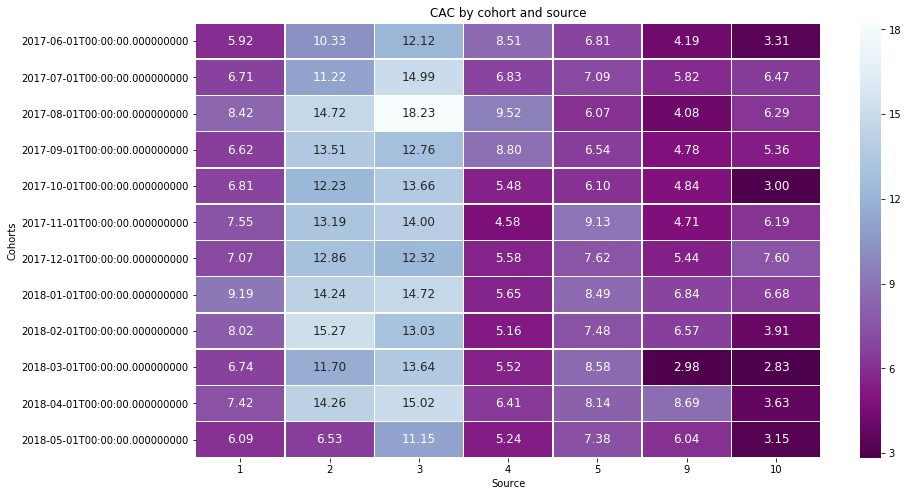

In [107]:
plt.figure(figsize=(14,8))
data = data.reindex(['Jun, 2017','Jul, 2017','Aug, 2017','Sep, 2017','Oct, 2017','Nov, 2017','Dec, 2017','Jan, 2018','Feb, 2018','Mar, 2018','Apr, 2018','May, 2018'])
ax = sns.heatmap(cac_source_pivot, annot=True, annot_kws={'size': 12}, fmt='.2f', linewidths=0.5, cmap="BuPu_r");        
plt.ylabel('Cohorts');
plt.xlabel('Source');
plt.title('CAC by cohort and source');

In [108]:
cac_source_pivot.mean()

source_id
1      7.212107
2     12.504068
3     13.802743
4      6.439374
5      7.451938
9      5.413892
10     4.867125
dtype: float64

На графике заметно, что стоимость привлечения одного покупателя разнится не только по источникам покупателей, но и по когортам.

#### ROI

Сначала посчитаем общий ROI (без детализации по источникам и устройствам), а затем сделаем детализацию.

In [109]:
buy_cohorts = pd.merge(buy_cohorts,costs_by_month[['month','costs']],left_on='first_order_month',right_on='month')

In [110]:
buy_cohorts = buy_cohorts.drop(columns='month')
buy_cohorts['cac'] = buy_cohorts['costs'] / buy_cohorts['cohort_users']
buy_cohorts['roi'] = buy_cohorts['ltv']/buy_cohorts['cac']

In [111]:
buy_cohorts_roi = buy_cohorts.pivot_table(
                        index='first_order_month',
                        columns='cohort_lifetime',
                        values='roi',
                        aggfunc='mean'
).round(2)

buy_cohorts_roi = buy_cohorts_roi.cumsum(axis=1)
buy_cohorts_roi.fillna('')

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,0.53,0.58,0.63,0.74,0.85,0.93,1.04,1.11,1.17,1.24,1.3,1.33
2017-07-01,0.63,0.67,0.74,0.78,0.8,0.82,0.83,0.84,0.86,0.88,0.9,
2017-08-01,0.49,0.53,0.57,0.61,0.66,0.69,0.71,0.75,0.78,0.8,,
2017-09-01,0.60,0.72,0.78,1.2,1.24,1.31,1.38,1.41,1.43,,,
2017-10-01,0.60,0.66,0.68,0.7,0.72,0.73,0.74,0.75,,,,
2017-11-01,0.55,0.59,0.61,0.64,0.66,0.67,0.68,,,,,
2017-12-01,0.54,0.57,0.68,0.8,0.84,0.88,,,,,,
2018-01-01,0.42,0.45,0.48,0.49,0.5,,,,,,,
2018-02-01,0.46,0.49,0.5,0.51,,,,,,,,


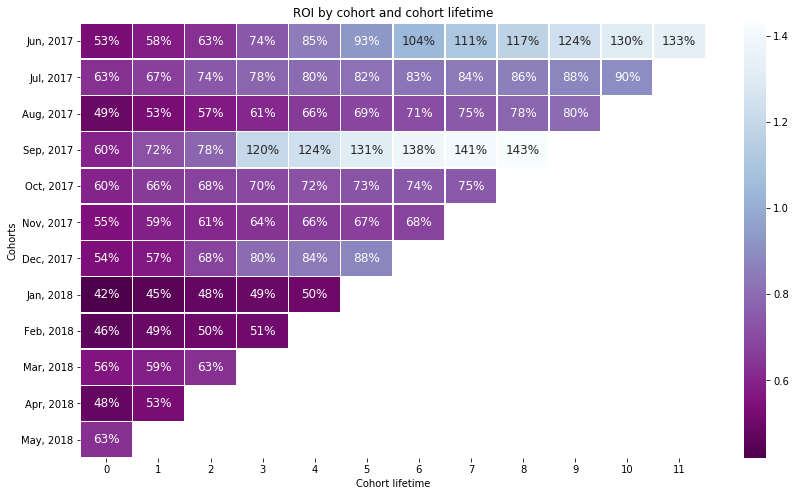

In [112]:
#heatmap(data,title,fmt,vmin=None, vmax=None)
heatmap(buy_cohorts_roi,'ROI by cohort and cohort lifetime','.0%')

In [113]:
buy_cohorts_roi.mean(axis=0)

cohort_lifetime
0     0.540833
1     0.580000
2     0.630000
3     0.718889
4     0.783750
5     0.861429
6     0.896667
7     0.972000
8     1.060000
9     0.973333
10    1.100000
11    1.330000
dtype: float64

В среднем когорты окупаются на 9-11 месяц жизни. Но внутри каждой когорты пользователи отличаются по источнику, из которого они пришли и по устройству, которым они пользовались, поэтому посмотрим на ROI в разрезе этих деталей.

In [114]:
cohorts_by_sources = (orders.groupby(['first_order_month','cohort_lifetime','source_id'])
                           .agg({'uid':'nunique','revenue':'sum'}).reset_index()
                     )

#посчитаем размеры когорт по каждому из источников
cohort_users_detailed = cohorts_by_sources[cohorts_by_sources['cohort_lifetime'] == 0][['first_order_month','uid','source_id']]
cohort_users_detailed = cohort_users_detailed.rename(columns={'uid':'cohort_users'})

#добавим размеры когорт в общую таблицу и посчитаем ltv
cohorts_by_sources = cohorts_by_sources.merge(cohort_users_detailed, on=['first_order_month','source_id'])
cohorts_by_sources['ltv'] = cohorts_by_sources['revenue'] / cohorts_by_sources['cohort_users']

In [115]:
cohort_users_detailed.head(5)

,first_order_month,cohort_users,source_id
0,2017-06-01,190,1
1,2017-06-01,235,2
2,2017-06-01,638,3
3,2017-06-01,413,4
4,2017-06-01,384,5


Добавим информацию о расходах, она содержится в costs_per_source:

In [116]:
costs_per_source.head(5)

,source_id,costs,first_order_month,n_buyers,costs_per_user
0,1,1125.61,2017-06-01,190,5.924263
1,2,2427.38,2017-06-01,235,10.329277
2,3,7731.65,2017-06-01,638,12.118574
3,4,3514.80,2017-06-01,413,8.510412
4,5,2616.12,2017-06-01,384,6.812813


In [117]:
cohorts_by_sources = cohorts_by_sources.merge(costs_per_source[['first_order_month','source_id','costs']], on=['first_order_month','source_id'])

Рассчитаем CAC и ROI:

In [118]:
cohorts_by_sources['cac'] = cohorts_by_sources['costs'] / cohorts_by_sources['cohort_users']
cohorts_by_sources['roi'] = cohorts_by_sources['ltv']/cohorts_by_sources['cac']

In [119]:
cohorts_by_sources.head(5)

,first_order_month,cohort_lifetime,source_id,uid,revenue,cohort_users,ltv,costs,cac,roi
0,2017-06-01,0,1,190,1378.70,190,7.256316,1125.61,5.924263,1.224847
1,2017-06-01,1,1,16,414.98,190,2.184105,1125.61,5.924263,0.368671
2,2017-06-01,2,1,10,419.43,190,2.207526,1125.61,5.924263,0.372625
3,2017-06-01,3,1,9,714.24,190,3.759158,1125.61,5.924263,0.634536
4,2017-06-01,4,1,12,811.20,190,4.269474,1125.61,5.924263,0.720676


Для каждого источника посчитаем накопительный ROI по месяцам жизни и отобразим его на графике:

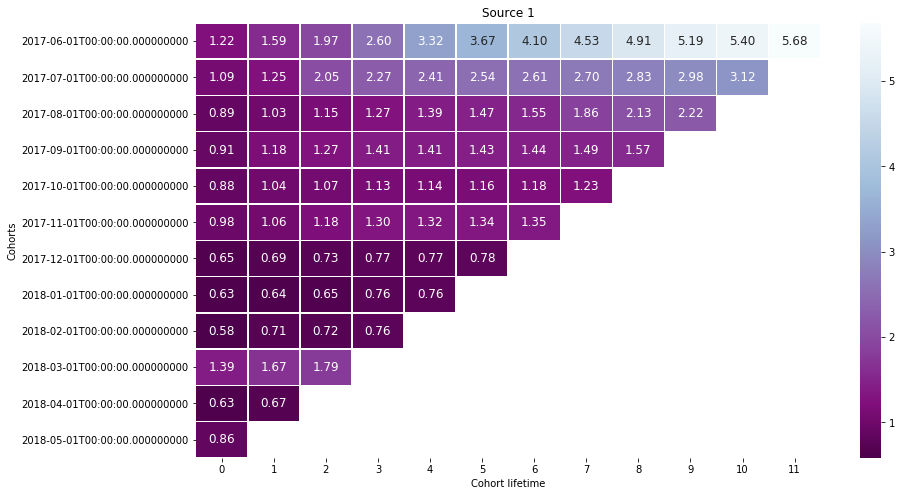

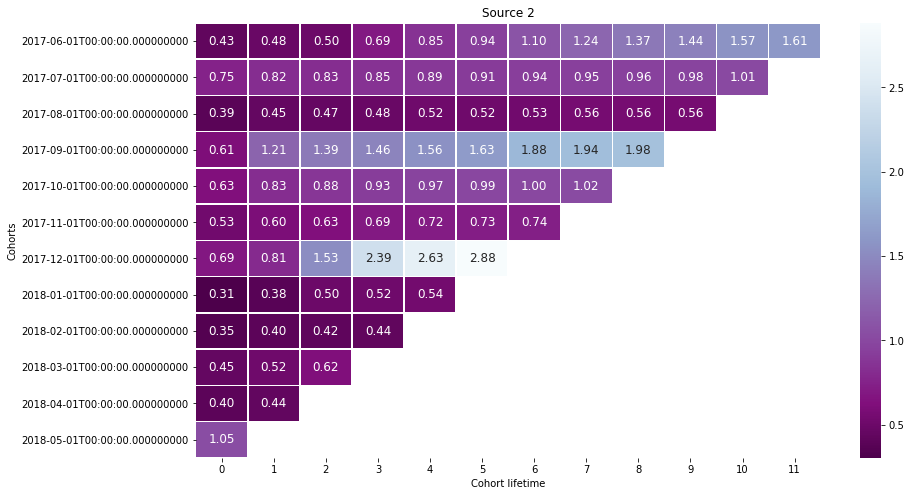

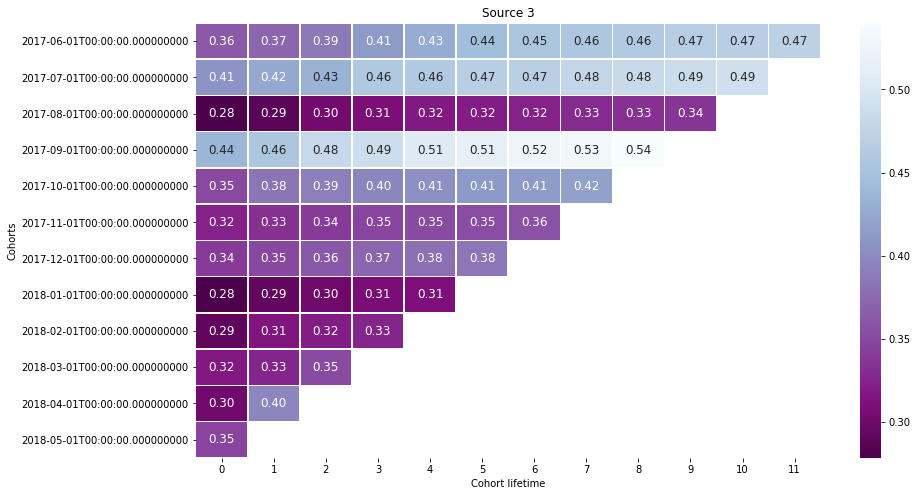

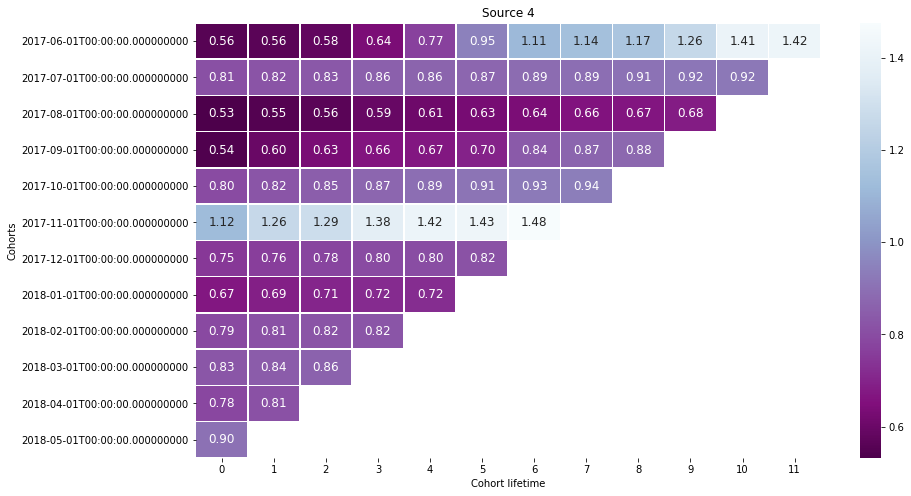

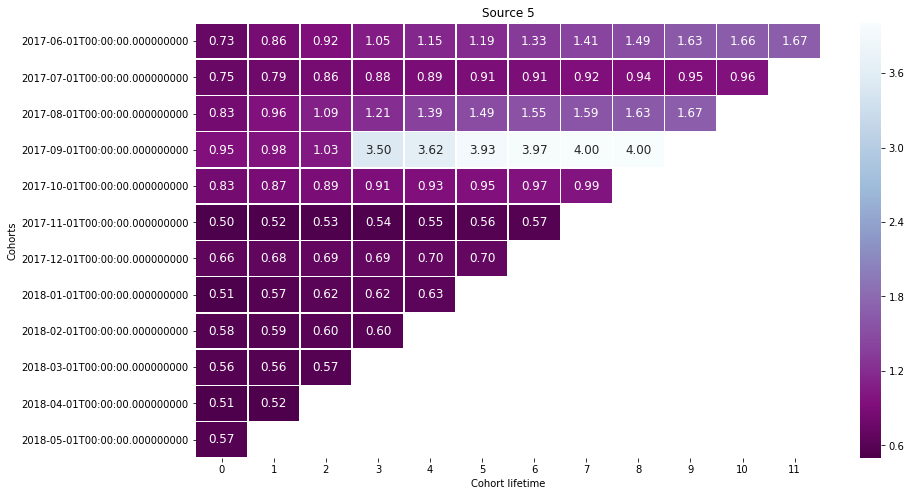

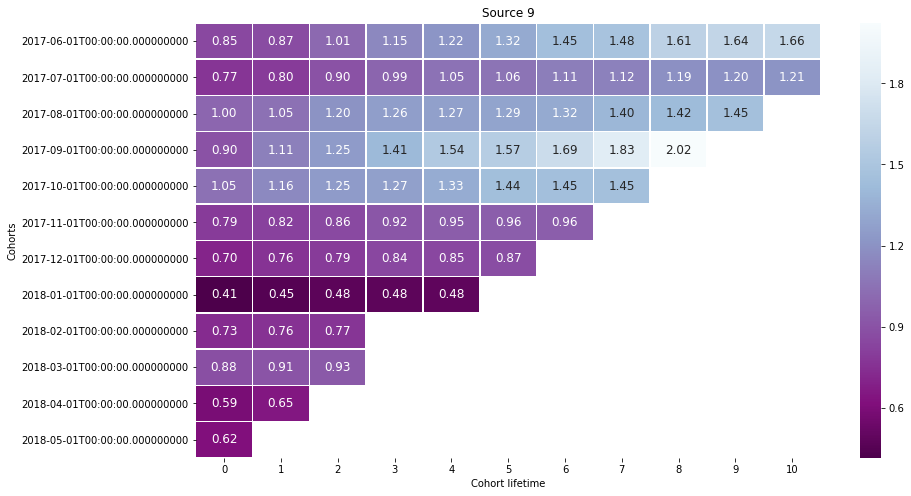

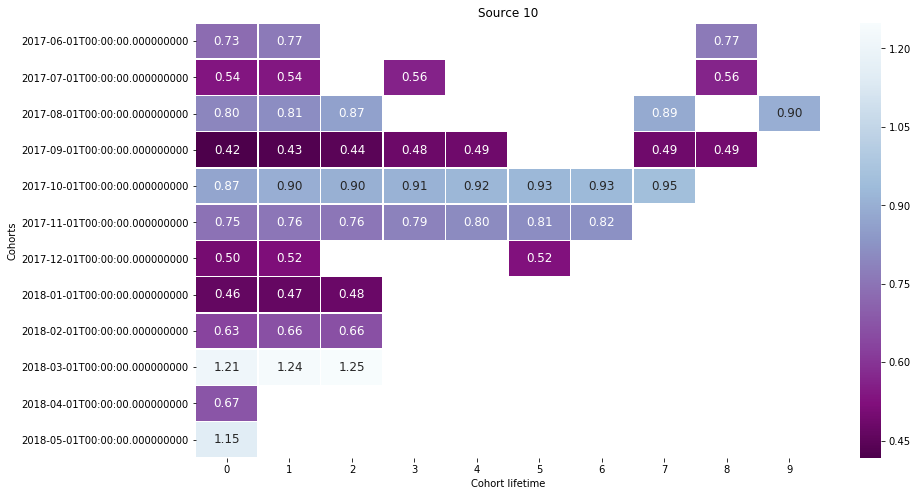

In [120]:
for source in cohorts_by_sources['source_id'].unique():
    pivot = cohorts_by_sources.query('source_id == @source').pivot_table(
                                                      index='first_order_month',
                                                      columns='cohort_lifetime',
                                                      values='roi',
                                                      aggfunc='mean')
    pivot = pivot.cumsum(axis=1)
    #не получилось сделать красивое отображение месяцев по оси y, выдавалась ошибка
    plt.figure(figsize=(14,8))
    ax = sns.heatmap(pivot, annot=True, annot_kws={'size': 12}, fmt='.2f', linewidths=0.5, cmap="BuPu_r");        
    plt.ylabel('Cohorts');
    plt.xlabel('Cohort lifetime');
    plt.title('Source {}'.format(source));

Мы видим, что даже по пользователям, пришедшим из одного источника, отличается период, когда когорты начинают окупаться. Так, например, по источнику 4 когорта ноября 2017 года окупилась в первый же месяц, в то время как когорта июля 2017 года не окупилась даже на десятый месяц. 

При обзоре расходов мы отмечали, что больше всего расходов приходится на источник 3, однако судя по графику когорты, пришедшие из этого источника не окупаются даже за год.

Для каждого источника усредним ROMI по всем когортам за каждый месяц их жизни, также добавим информацию о количестве пользователей из источника и о том, какая доля этих покупателей в общем количестве покупателей:

In [121]:
for source in cohorts_by_sources['source_id'].unique():
    pivot = cohorts_by_sources.query('source_id == @source').pivot_table(
                                                      index='first_order_month',
                                                      columns='cohort_lifetime',
                                                      values='roi',
                                                      aggfunc='mean')
    pivot = pivot.cumsum(axis=1).mean(axis=0)
    print('Source {}'.format(source))
    (print('Number of users from this source: {} users'
                      .format(cohorts_by_sources.query('source_id == @source and cohort_lifetime == 0')['cohort_users'].sum())))
    (print('% from total users: {:.1%}'
                      .format(cohorts_by_sources.query('source_id == @source and cohort_lifetime == 0')['cohort_users'].sum()
                              /cohorts_by_sources.query('cohort_lifetime == 0')['cohort_users'].sum())))
    display(pivot)

Source 1
Number of users from this source: 2899 users
% from total users: 7.9%


cohort_lifetime
0     0.892768
1     1.048742
2     1.258675
3     1.363425
4     1.565990
5     1.768576
6     2.038114
7     2.362370
8     2.860597
9     3.462846
10    4.256256
11    5.679045
dtype: float64

Source 2
Number of users from this source: 3506 users
% from total users: 9.6%


cohort_lifetime
0     0.549286
1     0.630051
2     0.777428
3     0.939189
4     1.085749
5     1.229496
6     1.029998
7     1.140317
8     1.215401
9     0.994079
10    1.290747
11    1.612957
dtype: float64

Source 3
Number of users from this source: 10473 users
% from total users: 28.7%


cohort_lifetime
0     0.336151
1     0.357750
2     0.367152
3     0.379767
4     0.394988
5     0.413851
6     0.423732
7     0.442706
8     0.454574
9     0.429613
10    0.479128
11    0.470834
dtype: float64

Source 4
Number of users from this source: 10295 users
% from total users: 28.2%


cohort_lifetime
0     0.757409
1     0.776915
2     0.791630
3     0.814921
4     0.843845
5     0.900297
6     0.980375
7     0.900496
8     0.904477
9     0.952753
10    1.165144
11    1.420471
dtype: float64

Source 5
Number of users from this source: 6931 users
% from total users: 19.0%


cohort_lifetime
0     0.664923
1     0.718179
2     0.779610
3     1.111582
4     1.231647
5     1.387731
6     1.549131
7     1.783598
8     2.016601
9     1.415622
10    1.306381
11    1.673333
dtype: float64

Source 9
Number of users from this source: 1088 users
% from total users: 3.0%


cohort_lifetime
0     0.774013
1     0.847641
2     0.943664
3     1.041018
4     1.086613
5     1.216218
6     1.331051
7     1.455936
8     1.559885
9     1.428569
10    1.432871
dtype: float64

Source 10
Number of users from this source: 1329 users
% from total users: 3.6%


cohort_lifetime
0    0.727377
1    0.708520
2    0.765743
3    0.685040
4    0.737312
5    0.754071
6    0.876620
7    0.773929
8    0.608024
9    0.899557
dtype: float64

Итак, подведем итоги (источники расположены по убыванию количества покупателей из них):

**Источник 3**  
Из данного источника пришло 10473 покупателей, что составляет 28.7%. Когорты из этого источника **не окупаются** за 12 месяцев жизни.

**Источник 4**  
Из данного источника пришло 10295 покупателей, что составляет 28.2%. Когорты из этого источника окупаются на **11** месяц жизни.

**Источник 5**  
Из данного источника пришло 6931 покупателей, что составляет 19%. Когорты из этого источника окупаются на **4** месяц жизни.

**Источник 2**  
Из данного источника пришло 3506 покупателей, что составляет 9.6%. В среднем когорты из этого источника окупаются на **5** месяц жизни.

**Источник 1**  
Из данного источника пришло 2899 покупателей, что составляет 8%. В среднем когорты из этого источника окупаются на **2** месяц жизни.

**Источник 10**  
Из данного источника пришло 1329 покупателей, что составляет 3,6%. Когорты из этого источника **не окупаются** за 12 месяцев жизни.

**Источник 9**  
Из данного источника пришло 1088 покупателей, что составляет 3%. В среднем когорты из этого источника окупаются на **4** месяц жизни.


Посчитаем ROI в зависимости от устройства покупателя. У нас нет информации о расходах в зависимости от устройства, но есть информация о расходах в зависимости от источника. И мы ранее уже рассчитали сумму расходов на одного покупателя по источникам. Воспользуемся этой информации для того, чтобы рассчитать сумму расходов на всех покупателей с определенного устройства.

In [122]:
costs_per_source.head(5)

,source_id,costs,first_order_month,n_buyers,costs_per_user
0,1,1125.61,2017-06-01,190,5.924263
1,2,2427.38,2017-06-01,235,10.329277
2,3,7731.65,2017-06-01,638,12.118574
3,4,3514.80,2017-06-01,413,8.510412
4,5,2616.12,2017-06-01,384,6.812813


In [123]:
cohorts_by_devices = (orders.groupby(['first_order_month','cohort_lifetime','source_id','device'])
                           .agg({'uid':'nunique','revenue':'sum'}).reset_index()
                     )

cohort_users_by_devices = cohorts_by_devices[cohorts_by_devices['cohort_lifetime'] == 0][['first_order_month','uid','source_id','device']]
cohort_users_by_devices = cohort_users_by_devices.rename(columns={'uid':'cohort_users'})

cohorts_by_devices = cohorts_by_devices.merge(cohort_users_by_devices, on=['first_order_month','source_id','device'])
cohorts_by_devices['ltv'] = cohorts_by_devices['revenue'] / cohorts_by_devices['cohort_users']


In [124]:
cohort_users_by_devices.head(5)

,first_order_month,cohort_users,source_id,device
0,2017-06-01,163,1,desktop
1,2017-06-01,27,1,touch
2,2017-06-01,191,2,desktop
3,2017-06-01,44,2,touch
4,2017-06-01,564,3,desktop


In [125]:
cohorts_by_devices = cohorts_by_devices.merge(costs_per_source[['first_order_month','source_id','costs_per_user']], on=['first_order_month','source_id'])

In [126]:
cohorts_by_devices = cohorts_by_devices.rename(columns={'costs_per_user':'cac'})
cohorts_by_devices['roi'] = cohorts_by_devices['ltv'] / cohorts_by_devices['cac']

In [127]:
cohorts_by_devices

,first_order_month,cohort_lifetime,source_id,device,uid,revenue,cohort_users,ltv,cac,roi
0,2017-06-01,0,1,desktop,163,1249.17,163,7.663620,5.924263,1.293599
1,2017-06-01,1,1,desktop,15,413.15,163,2.534663,5.924263,0.427844
2,2017-06-01,2,1,desktop,10,419.43,163,2.573190,5.924263,0.434348
3,2017-06-01,3,1,desktop,8,692.92,163,4.251043,5.924263,0.717565
4,2017-06-01,4,1,desktop,10,768.36,163,4.713865,5.924263,0.795688
...,...,...,...,...,...,...,...,...,...,...
877,2018-05-01,0,5,touch,93,359.02,93,3.860430,7.383421,0.522851
878,2018-05-01,0,9,desktop,49,188.36,49,3.844082,6.036167,0.636842
879,2018-05-01,0,9,touch,11,34.69,11,3.153636,6.036167,0.522457
880,2018-05-01,0,10,desktop,95,373.58,95,3.932421,3.152769,1.247291


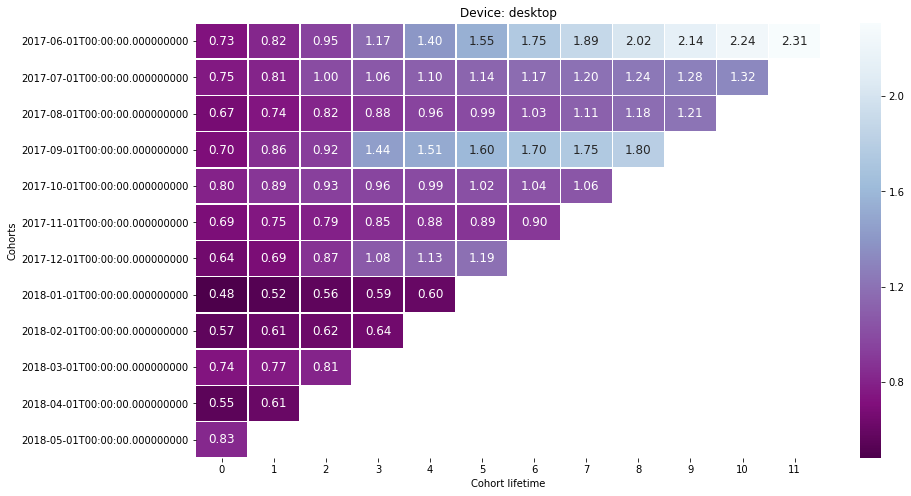

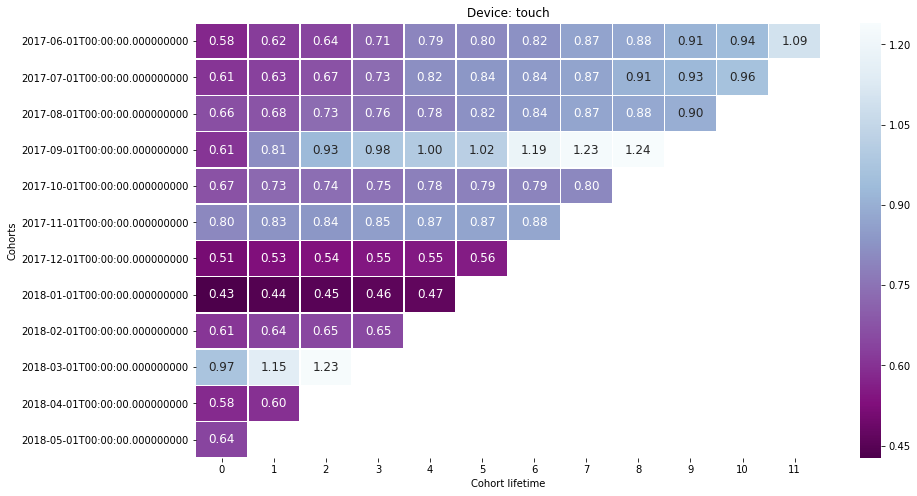

In [128]:
for device in cohorts_by_devices['device'].unique():
    pivot = cohorts_by_devices.query('device == @device').pivot_table(
                                                      index='first_order_month',
                                                      columns='cohort_lifetime',
                                                      values='roi',
                                                      aggfunc='mean')
    pivot = pivot.cumsum(axis=1)
    #не получилось сделать красивое отображение месяцев по оси y, выдавалась ошибка
    plt.figure(figsize=(14,8))
    ax = sns.heatmap(pivot, annot=True, annot_kws={'size': 12}, fmt='.2f', linewidths=0.5, cmap="BuPu_r");        
    plt.ylabel('Cohorts');
    plt.xlabel('Cohort lifetime');
    plt.title('Device: {}'.format(device));

In [129]:
for device in cohorts_by_devices['device'].unique():
    pivot = cohorts_by_devices.query('device == @device').pivot_table(
                                                      index='first_order_month',
                                                      columns='cohort_lifetime',
                                                      values='roi',
                                                      aggfunc='mean')
    pivot = pivot.cumsum(axis=1).mean(axis=0)
    print('Device: {}'.format(device))
    (print('Number of users using this device: {} users'
                      .format(cohorts_by_devices.query('device == @device and cohort_lifetime == 0')['cohort_users'].sum())))
    (print('% from total users: {:.1%}'
                      .format(cohorts_by_devices.query('device == @device and cohort_lifetime == 0')['cohort_users'].sum()
                              /cohorts_by_devices.query('cohort_lifetime == 0')['cohort_users'].sum())))
    display(pivot)

Device: desktop
Number of users using this device: 29209 users
% from total users: 80.0%


cohort_lifetime
0     0.678804
1     0.733213
2     0.827003
3     0.965700
4     1.070943
5     1.197614
6     1.264523
7     1.401131
8     1.558975
9     1.542751
10    1.779212
11    2.307351
dtype: float64

Device: touch
Number of users using this device: 7312 users
% from total users: 20.0%


cohort_lifetime
0     0.639922
1     0.695892
2     0.742000
3     0.715891
4     0.756679
5     0.813510
6     0.892953
7     0.927422
8     0.979358
9     0.913677
10    0.949318
11    1.094467
dtype: float64

80% покупателей пользуются устройством типа desktop и в среднем когорты таких пользователей окупаются на 5 месяц. Прочие 20% пользователей пользуются устройством типа touch - в среднем когорты таких пользователей окупаются на 12 месяц.

## Вывод

Итак, ответим на поставленные вопросы в начале данного шага:

**1)** Сколько денег потратили? Всего / на каждый источник / по времени  

Всего за период с июня 2017 по май 2018 года было потрачено 329 131.62 руб. Больше всего расходов было потрачено на источник 3, в среднем 43% за все 12 месяцев. Следующий по убыванию источник под номером 4 - 19%, затем следует источник под номером 5 - 15.7%. Ежемесячно структура расходов по источникам существенно не изменялась. Основная доля расходов была понесена в период с октября по декабрь 2017 года, летом 2017 года расходы были самые низкие за исследуемый период.

**2)** Сколько стоило привлечение одного покупателя из каждого источника?  

В среднем привлечение одного покупателя из каждого источника стоило:

3 источник - 13.8 руб.  
2 источник - 12.5 руб.  
5 источник - 7.5 руб.  
1 источник - 7.2 руб.  
4 источник - 6.4 руб.  
9 источник - 5.4 руб.  
10 источник - 4.9 руб.  

**3)** На сколько окупились расходы? (ROI)

Окупаемость зависит и от источника, с которого пришли покупатели, и от устройства, которым покупатели пользуются.
В среднем когорты полностью окупаются на 9-11 месяц жизни. 
При этом если смотреть детально, то когорты пользователей, пришедших из источника 3 (самого дорогого источника по расходам на 1 покупателя), не окупились за все 12 месяцев жизни. При этом такие пользователи составляют около 29% от всех покупателей. Когорты покупателей, пришедших из источника 4 (их доля составляет 28%) окупаются на 11 месяц жизни. Есть когорты, которые окупаются быстрее, например, когорты покупателей из источника 1 (на 2й месяц), источника 5 и источника 9 (на 4й месяц), однако доля таких покупателей меньше.

# 4. Общий вывод.  <a name="4step"></a>

Целью данного проекта является оптимизация маркетинговых затрат Яндекс.Афиши. Для этой цели мы проанализировали данные за 12 месяцев: с июня 2017 по май 2018 г. 

В данном проекте продуктом является сайт Яндекс.Афиша, на котором собрана информация о различных мероприятиях. Сайтом можно пользоваться просто как источником информации, чтобы быть в курсе событий, с целью прочитать отзывы о спектаклях или фильмах, построить планы на выходные. Но также можно пользоваться сервисом для приобретения билетов: Яндекс.Афиша выступает посредником между продавцами и пользователем, поэтому для пользователя нет необходимости обращаться напрямую к продавцу, а можно сделать заказ на сайте Яндекс.Афиши.

В **первом шаге** мы исследовали продукт: как часто им пользуются, как долго длится сессия, сколько сессий приходится на одного пользователя в день. Мы получили следующие выводы:  

*  день среднее количество уникальных пользователей составляло 907 пользователей. За неделю в среднем количество уникалльных пользователей составляло 5716 человек, а за месяц - 23228 человек. Фактор липкости (sticky factor) на основании этих значений составлял 4% по отношению к месячной аудитории и 16% по отношению к недельной аудитории. Значение показателя достаточно низкое, что говорит о низкой вовлеченности пользователей.

* в среднем один уникальный юзер посещает сайт 1 раз в день. В месяц один пользователь в среднем заходит на сайт также 1 раз. 

* медианное значение продолжительности сессии составляет 5 минут, однако мода - значение, которое встречается чаще всего - 1 минута. То есть чаще всего продолжительность посещения сайта составляет одну минуту. Вряд ли за это время пользователь успевает сделать заказ.

* пользователи возвращаются не часто и вероятно лишь по потребности приобрести билет или выбрать мероприятие. Через месяц после первого посещения максимальное значение retention rate составило 8,5% пользователей, для когорты сентября 2017 года, для других когорт возвращаемость составляла от 4,2% (когорта марта 2018) до 7,9%. В последующие месяцы возвращаемость падает.

Из выводов по первому шагу можно дать следующие рекомендации:  
**1)** необходимо привлекать больше уникальных пользователей на сайт и мотивировать их возвращаться  
**2)** необходимо проверить, понимают ли пользователи возможности сайта: знают ли о возможности приобрести билет через сайт или пользуются Яндекс.Афишей, чтобы только узнать о событии, а покупать переходят на сторонние сайты  

Во **втором шаге** мы исследовали продажи: когда начинают покупать, какой средний чек и количество заказов, сколько денег приносят покупатели:

* Промежуток между первым посещением и первой покупкой очень разнится для пользователей. Среднее значение составляет 24341 минуту, что составляет около 17 дней. Однако такое большое среднее значение связано с наличием пользователей с большим промежутком времени. Медианное значение составляет 16 минут, 50% наших пользователей делает первую покупку в промежуток до 16 минут. Количество пользователей, первая покупка которых произошла позднее, чем через 5 дней составляет 21%.

* 82% всех заказов было сделано с первый же месяц покупки. Повторно за заказами приходит небольшое количество пользователей. Однако если в первый месяц в среднем один пользователь делает один заказ, то в последующие месяцы пользователи делают больше заказов - до 3-4 в некоторых когортах. Вероятно возвращаются лояльные пользователи, которые активно посещают мероприятия и предпочитаю покупать билеты на Яндекс.Афише.

* Средний чек варьируется по месяцам и по когортам. Средний чек за весь период по всем когортам составлят 5 руб.

* За 6 месяцев средняя выручка пользователей, первый раз совершивших покупку в июне-декабре 2017 года составила 7.97 рублей.

Из выводов по второму шагу мы можем дать рекомендации:  
**1)** стимулировать покупателей к повторным покупкам. Из нашего анализа следует, что возвращаются более лояльные покупатели и они делают бОльшее количество заказов в последующие месяцы. Из этого следует, что чем больше будет возвращаться покупателей, тем больше потенциальная выручка от этих покупателей

В **третьем шаге** мы исследовали маркетинговые расходы:

* Всего за период с июня 2017 по май 2018 года было потрачено 329 131.62 руб. Больше всего расходов было потрачено на источник 3, в среднем 43% за все 12 месяцев. Следующий по убыванию источник под номером 4 - 19%, затем следует источник под номером 5 - 15.7%. Ежемесячно структура расходов по источникам существенно не изменялась. Основная доля расходов была понесена в период с октября по декабрь 2017 года, летом 2017 года расходы были самые низкие за исследуемый период.

* Сумма расходов за 12 месяцев превысила сумму доходов за этот период

* Самыми дорогими источниками являлись источник 3 (13,8 руб/1 покупатель) и источник 2 (12,5 руб./1 покупатель). Суммарно оба этих источника привлекли 38,3% пользователей. Источник 4 (6,4 руб./1 покупатель) привлек 28% пользователей.

* в среднем когорты полностью окупаются на 9-11 месяц жизни

Из выводов по третьему шагу мы можем дать рекомендации: 

**1)** перераспределить бюджет таким образом, чтобы сократить процент расходов на источник 3. Этот источник приносит большое количество пользователей, но при этом это самый дорогой источник и он не окупается даже за 12 месяцев. Перераспределить можно по всем прочим источникам, кроме источника 10 (он не окупается). При этом рекомендацией будет оставить источник 3 и следить за метриками (ltv,cac,roi) в течение всего периода эксперимента. Если удастся получать то же и даже большее количество покупателей из других источников, то мы сможем отказаться от использования источника 3 или сократить его до оптимального уровня

**2)** в качестве эксперимента отключить источник 10, перераспределить бюджет на этот источник на другие источники

